# Server connection check

In [1]:
from typing import Any

# In this notebook we are not generating attack data (we did that in v0.3.0) but we are loading the attack data and testing the model with explanations.

# Here we are making the LOOP

print('hello')
import os
from sys import executable as exec
print('current working directory: ', os.getcwd())
print('current conda environment: ', exec)

#--notebook-dir=/home/spatial01/RND/adversarial-detector/adversarial-detector-xai

hello
current working directory:  /home/spatial01/RND/adversarial-detector/adversarial-detector-xai
current conda environment:  /home/spatial01/anaconda3/envs/netslab_lime_defense/bin/python


In [2]:
# %load_ext autoreload
# %autoreload 2

## Testing if Torch is working correclty
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.3788, 0.1243, 0.0144],
        [0.6471, 0.4288, 0.5675],
        [0.5873, 0.3755, 0.9444],
        [0.9942, 0.5648, 0.2464],
        [0.1237, 0.7444, 0.7268]])


# Imports

In [3]:

# Eager execution shit in tensorflow

import os
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import datetime as dt
import pandas as pd
import deprecation
from pprint import pp as pprint

# %% Machine Learning
from sklearn.model_selection import train_test_split

# reload and load custom modules
import importlib
import myutils
import codb_utils
importlib.reload(codb_utils)
importlib.reload(myutils)
from myutils import create_dir_if_not_exist, get_latest_file, to_dataLoader, PyTorchPredWrapper, load_latest_model, get_latest_model, conv_double_to_single_col_binary_labels

# Experiment loop
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support

# pytorch
from torch import optim, nn, Tensor
import torch
import lightning as L
from torchmetrics import Accuracy

plt.rcParams['figure.figsize'] = [12, 8] # Set default plot size

# paths
# Change the date here to use the files from a different date
proj_root = os.getcwd()
# Loading datasets
load_dlcb_data_dir = os.path.join(os.getcwd(), "data/DeepMIMO_data/DLCB_dataset_21-07-24/")
load_adv_fgsm_data_dir = os.path.join(proj_root, "results/Novel_DMIMO_21-03-24/AdvData/")
load_adv_cw_data_dir = os.path.join(proj_root, "results/Novel_DMIMO_28-04-24/AdvData/")
load_all_adv_data_dir = os.path.join(proj_root, "results/Novel_DMIMO_02-05-24/AdvData/")
load_xai_data_dir = os.path.join(proj_root, "results/Novel_DMIMO_12-04-24/Explanations/")
# Loading logs
load_lighting_logs_dir = os.path.join(proj_root, "lightning_logs/")
# Loading results and observations
load_results_dir = os.path.join(proj_root, "results/Novel_DMIMO_15-04-24/Observations/")
# Loading trained models
load_adv_detector_dir = os.path.join(proj_root, "results/Novel_DMIMO_11-04-24/Models/adv_detector/")
load_dlcb_models_dir = os.path.join(proj_root, "results/Novel_DMIMO_26-04-24/Models/dlcb_models/")

path_base=os.path.join(os.getcwd(), "results/Novel_DMIMO_")
# Create directories
results_dir = create_dir_if_not_exist(os.path.join(os.getcwd(), "results/Novel_DMIMO_"+dt.datetime.now().strftime("%d-%m-%y")))
results_figs_dir = create_dir_if_not_exist(os.path.join(results_dir, 'Figs'))
results_data_dir = create_dir_if_not_exist(os.path.join(results_dir, 'Observations'))
results_adv_data_dir = create_dir_if_not_exist(os.path.join(results_dir, 'AdvData'))
results_explanations_dir = create_dir_if_not_exist(os.path.join(results_dir, 'Explanations'))
results_models_dir = create_dir_if_not_exist(os.path.join(results_dir, 'Models'))
results_xai_detector_dir = create_dir_if_not_exist(os.path.join(results_models_dir, 'xai_detector'))
results_adv_detector_dir = create_dir_if_not_exist(os.path.join(results_models_dir, 'adv_detector'))
results_dlcb_models_dir = create_dir_if_not_exist(os.path.join(results_models_dir, 'dlcb_models'))

# CONFIGURATION
# Make it False to train the model
LOAD_XAI_ADVERSARIAL_MODEL_FROM_FILE = False
modifier_txt_direct_adv_det = 'Full_direct_adv_DF, lr 1e-3, three_layers'
modifier_txt_xai_adv_det = 'Full_XAI_DF, lr 1e-3'
modifier_txt_xgboost_zero_day='Unseen_XGBoost_Tr-FGSM_Ts-FGSM-CWL2'
modifier_txt_skl_mlp_zero_day='Unseen_SKL_MLP_Tr-FGSM_Ts-FGSM-CWL2'
modifier_txt_skl_mlp_adv_det = 'SKL_MLP_Tr-FGSM_Ts-FGSM'
modifier_txt_xgboost_adv_det = 'XGBoost_Tr-FGSM_Ts-FGSM'
# Make it False to train the model
LOAD_DIRECT_ADVERSARIAL_MODEL_FROM_FILE = False
TRAIN_XGBOOST_ADV_ZERO_DAY=True
TRAIN_SKL_MLP_ADV_ZERO_DAY=True
# Make this 2 or 3 for testing and 1.0 (float) for the full dataset
CONFIG_TRAIN_LIMIT = 1.0
# Batch size for both direct and XAI detectors
DMAD_BATCH_SIZE = 32
CREATE_ATTACK_DATASETS = False

data_directories = {
    'dlcb_data_load': load_dlcb_data_dir,
    'dlcb_model_save': results_dlcb_models_dir,
    'dlcb_model_load': load_dlcb_models_dir,
    'fgsm_data_load': load_adv_fgsm_data_dir,
    'xai_data_load': load_xai_data_dir,
    'adv_data_save': results_adv_data_dir,
    'xai_data_save': results_explanations_dir,
}

import tensorflow as tf
try:
    importlib.reload(tf)
except ValueError as ve:
    print("Eager execution is already enabled: ", ve)
# Change this when you want to train the DLCB original tensorflow model
DLCB_TRAINING = False
if DLCB_TRAINING:
    LOAD_DLCB_MODELS=False
    tf.compat.v1.enable_eager_execution()
elif not DLCB_TRAINING:
    LOAD_DLCB_MODELS=True
    tf.compat.v1.disable_eager_execution()


# Stop running the main loop
RUN_LOOP = False
GENERATE_EXPL_PLOTS = False
TDD_loop = False
RUNTIME_VIZ = False

2025-02-25 08:10:10.867736: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 08:10:10.872044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 08:10:10.929833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 08:10:10.929872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 08:10:10.929908: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [4]:
# TODO - Add the code to sve the adversarial detector y values
# TODO - Add the code to load the y values for XAI detector
# TODO - Write all the save functions as well

class DmadDatasets:
    def __init__(self, directories, task=None):
        self.random_seed = 2024
        self.directories = directories
        self.shuffle= True
        self.xai_X = None
        self.xai_ev = None
        self.adv_X = None
        self.adv_y = None
        self.dlcb_X = None
        self.dlcb_y = None
        self.task_data = None
        self.task_name = task
        self.sub_datasets=None
    
    @staticmethod
    def load_dlcb_data(data_dir):
        input_data_path = os.path.join(data_dir, 'DLCB_input.mat')
        output_data_path = os.path.join(data_dir, 'DLCB_output.mat')
        In_set, Out_set = loadmat(input_data_path)['DL_input'], loadmat(output_data_path)['DL_output']
        return In_set, Out_set
    
    @staticmethod
    def stack_data(sub_dataset_dict, key_prefix=None):
        datasets_to_concat = []
        for key, value in sub_dataset_dict.items():
            if key.startswith(key_prefix):
                datasets_to_concat.append(value)
        full_data = np.concatenate(datasets_to_concat, axis=0)
        return full_data
    
    @staticmethod
    def load_adv_detector_data(data_dir, ext='adv_*.npy'):
        return np.load(get_latest_file(data_dir, ext))
    
    @staticmethod
    def load_xai_adv_detector_data(data_dir):
        expl_data =  np.load(get_latest_file(data_dir, 'Expl_s*.npy'))
        expl_expected_value = np.load(get_latest_file(data_dir, 'Expl_EV_s*.npy'))
        return expl_data, expl_expected_value
    
    @staticmethod
    def print_details(dataset_dict):
        for key, value in dataset_dict.items():
            print(f"{key}: {value.shape}")
    
    @staticmethod   
    def _check_validation(test_size, validation_size, full_df):
        if validation_size is None:
            validation_size = None
        elif isinstance(validation_size, int) and isinstance(test_size, float):
            validation_size = validation_size
        elif isinstance(validation_size, float) and isinstance(test_size, int):
            validation_size = validation_size/(1-(test_size/np.shape(full_df)[0]))
        elif isinstance(validation_size, float) and isinstance(test_size, float):
            validation_size = validation_size/(1-test_size)
        else:
            validation_size = validation_size
        return validation_size
    
    @staticmethod
    def _create_dict_from_subds(datasets):
        if len(datasets) > 4:
            return {
                'X_train': datasets[0],
                'X_test': datasets[1],
                'X_val': datasets[2],
                'y_train': datasets[3],
                'y_test': datasets[4],
                'y_val': datasets[5]
            }
        else:
            return {
                'X_train': datasets[0],
                'X_test': datasets[1],
                'y_train': datasets[2],
                'y_test': datasets[3]
            }
    
    @staticmethod
    @deprecation.deprecated(deprecated_in="0.1.0", current_version="0.1.1",
                        details="Use the create_detector_full_ds_adding_labels for multiple adversarial and benign dataset")
    def _create_detector_labels(adv_data: np.array, benign_data: np.array):
        """
        Create a dataset for the adversarial detector
        """
        if adv_data.shape[1] == benign_data.shape[1]:
            # Create output set for the adversarial dataset
            adv_Out_set = np.ones((adv_data.shape[0],1), dtype=int)
            # Create output for the benign dataset
            benign_Out_set = np.zeros((benign_data.shape[0],1), dtype=int)
            # Concatenate the adversarial and benign datasets
            full_In = np.concatenate((adv_data, benign_data), axis=0)
            # Concatenate the output sets
            full_Out = np.concatenate((adv_Out_set, benign_Out_set), axis=0)
            full_Out = np.squeeze(full_Out.T) #Important - Because this will help with the loss function otherwise columns are not supported
        else:
            raise NotImplementedError("The adversarial and benign data features are not the same")
        return full_In, full_Out
    
    @staticmethod
    def create_detector_full_ds_adding_labels(adv_data: [np.array], benign_data: [np.array]):
        adv_data_labels = []
        for i, ds in enumerate(adv_data):
            adv_data_labels.append(np.ones((adv_data[i].shape[0]), dtype=int)*(i+1))
        benign_x = np.concatenate(benign_data, axis=0)
        benign_y = np.zeros((benign_x.shape[0]), dtype=int)
        adv_x = np.concatenate(adv_data, axis=0)
        adv_y = np.concatenate(adv_data_labels, axis=0)
        full_X = np.concatenate((benign_x, adv_x), axis=0)
        full_y = np.concatenate((benign_y, adv_y), axis=0)
        return full_X, full_y
    
    @staticmethod
    def _conv_labels_to_multidim(y):
        return np.array([[1, 0] if x == 0 else [0, 1] for x in y])

    def load_dataset(self, name=None):
        if name == 'dlcb':
            self.dlcb_X, self.dlcb_y = DmadDatasets.load_dlcb_data(self.directories['dlcb_data_load'])
        elif name == 'adv_detector':
            self.adv_X = DmadDatasets.load_adv_detector_data(self.directories['fgsm_data_load'])
            self.dlcb_X, _ = DmadDatasets.load_dlcb_data(self.directories['dlcb_data_load'])
        elif name == 'xai_detector':
            self.xai_X, self.xai_ev = DmadDatasets.load_xai_adv_detector_data(self.directories['xai_data_load'])
        else:
            raise ValueError("Invalid dataset name")
        return self
    
    def get_dlcb_x_real(self):
        return self.dlcb_X.real
    
    def get_dlcb_y_real(self):
        return self.dlcb_y.real
    
    @staticmethod
    def get_matching_label(dict_to_search, input_key):
        # From the data, get the matching label key for the given input key. 
        # For example from X_test, you will get the y_test. 
        dict_keys_ls = list(dict_to_search.keys())
        if input_key in dict_keys_ls:
            dict_keys_ls.remove(input_key)
            matching_key = f"y_{input_key.split('_')[1]}"
            if matching_key in dict_to_search.keys():
                return matching_key
            else:
                print(f"{matching_key} is not a good a good guess from my side!")
        else:
            print(f"{input_key} key is not in the sub_datasets dictionary")
    
    def get_corresponding_label_ds(self, dataset_key=None):
        # from the received y key, get the corresponding y dataset
        if self.sub_datasets is not None: 
            return self.sub_datasets[DmadDatasets.get_matching_label(self.sub_datasets, dataset_key)]
        else:
            print("Create the sub_datasets first. For this you need to run a task!")
        
    def filter_data_from_label(self, dataset_key=None, label=None):
        # This function filters out the rows of the dataset with the key 'dataset_key' based on the value of the label matching in the corresponding labels dataset
        # TODO: How to handle when the labels are multi dimensional
        if self.get_corresponding_label_ds(dataset_key).ndim == 1:
            return self.sub_datasets[dataset_key][self.get_corresponding_label_ds(dataset_key)==label]

    def _split_test_validation(self, X, y, test_size=0.2, validation_size=None, shuffle=True, stratify=None):
        if self.task_name != 'dlcb':
            stratify = y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=self.random_seed, shuffle=shuffle, stratify=stratify)
        if validation_size is not None:
            if self.task_name != 'dlcb':
                stratify = y_train
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=self.random_seed, shuffle=shuffle, stratify=stratify)
            self.adv_y = np.concatenate((y_train, y_test, y_val), axis=0)
            return DmadDatasets._create_dict_from_subds([X_train, X_test, X_val, y_train, y_test, y_val])
        self.adv_y = np.concatenate((y_train, y_test), axis=0)
        return DmadDatasets._create_dict_from_subds([X_train, X_test, y_train, y_test])
    
    def get_full_unprocessed_dataset(self, name=None):
        if name == 'dlcb':
            return self.dlcb_X, self.dlcb_y
        elif name == 'adv_detector':
            return self.adv_X, self.adv_y
        elif name == 'xai_detector':
            return self.xai_X, self.adv_y
        else:
            raise ValueError("Invalid dataset name")
    
    def concatenate_sub_datasets(self, data_key='both'):
        # A function that takes a dictionary of string keys and numpy arrays as values and concatenate the numpy arrays where the keys start with y are in one array and the keys start with X are in another array
        X_arrays = []
        y_arrays = []
        if data_key=='X':
            for key, value in self.sub_datasets.items():
                if key.startswith('X'):
                    X_arrays.append(value)
            return np.concatenate(X_arrays, axis=0)
        if data_key=='y':
            for key, value in self.sub_datasets.items():
                if key.startswith('y'):
                    y_arrays.append(value)
        if data_key=='both':
            for key, value in self.sub_datasets.items():
                if key.startswith('y'):
                    y_arrays.append(value)
                elif key.startswith('X'):
                    X_arrays.append(value)
            return np.concatenate(X_arrays, axis=0), np.concatenate(y_arrays, axis=0)
        
    def set_random_seed(self, seed):
        self.random_seed=seed
        
    def set_shuffle(self, shuffle):
        self.shuffle=shuffle
    
    @staticmethod
    def save_adv_data(folder_path, modifier, X, y=None):
        np.save(os.path.join(folder_path, f"adv_X_{modifier}_{dt.datetime.now().strftime('%H-%M-%S')}.npy"), X, allow_pickle=False)
        if y is not None:
            np.save(os.path.join(folder_path, f"adv_y_{modifier}_{dt.datetime.now().strftime('%H-%M-%S')}.npy"), y, allow_pickle=False)
        return True            
        
    def dlcb_pred_task(self, test_size=None, validation_size=None, real_part_only=True, verbose=False):
        """
        Returns the training and testing data for the DLCB dataset
        test_size: should be out of the full dataset
        validation_size: should be out of the full dataset
        """
        if self.dlcb_X is None or self.dlcb_y is None:
            self.load_dataset('dlcb')
        
        if real_part_only:
            self.dlcb_X = self.dlcb_X.real
            
        validation_size = DmadDatasets._check_validation(test_size, validation_size, self.dlcb_X)
        
        # self.task_data = DmadDatasets._create_dict_from_subds([self.dlcb_X, self.dlcb_y])
        
        self.sub_datasets = self._split_test_validation(X=self.dlcb_X, y=self.dlcb_y, test_size=test_size, validation_size=validation_size, shuffle=self.shuffle)
        if verbose:
            DmadDatasets.print_details(self.sub_datasets)
        return self.sub_datasets
    
    def adv_detector_task(self, multidim_labels=False, test_size=None, validation_size=None, real_part_only=True, verbose=False):
        if self.dlcb_X is None or self.adv_X is None:
            self.load_dataset('adv_detector')
            
        if real_part_only:
            self.dlcb_X = self.dlcb_X.real
            
        validation_size = DmadDatasets._check_validation(test_size, validation_size, self.dlcb_X)
        
        det_In, det_out = DmadDatasets._create_detector_labels(self.adv_X, self.dlcb_X)
        
        if multidim_labels:
            det_out = DmadDatasets._conv_labels_to_multidim(det_out)
            
        det_out = det_out.astype(int)

        self.sub_datasets = self._split_test_validation(X=det_In, y=det_out, test_size=test_size, validation_size=validation_size, shuffle=self.shuffle)
        if verbose:
            DmadDatasets.print_details(self.sub_datasets)
        return self.sub_datasets

    def xai_adv_detector_task(self, test_size=None, validation_size=None, verbose=False, explanations_class=0, multidim_labels=False):
        if self.xai_X is None:
            self.load_dataset('xai_detector')
        # TODO: Patch fix for the problem of not saving the y values. Save the y values of adv task in the future in this way we are relying on the random seed - not a good practice
        if self.adv_y is None:
            self.adv_detector_task(test_size=0.2, validation_size=0.1, real_part_only=True, multidim_labels=True)
        
        validation_size = self._check_validation(test_size, validation_size, self.xai_X)
        
        xai_det_in= self.xai_X[explanations_class]
        xai_det_out = self.adv_y

        if multidim_labels:
            if len(xai_det_out.shape) == 1:
                xai_det_out = DmadDatasets._conv_labels_to_multidim(xai_det_out)
            elif len(xai_det_out.shape)>1:
                xai_det_out = xai_det_out
        else:
            if len(xai_det_out.shape)==1:
                xai_det_out = xai_det_out  
            elif len(xai_det_out.shape)==2:
                xai_det_out = conv_double_to_single_col_binary_labels(xai_det_out) 
        
        self.sub_datasets = self._split_test_validation(X=xai_det_in, y=xai_det_out, test_size=test_size, validation_size=validation_size, shuffle=self.shuffle)
        if verbose:
            DmadDatasets.print_details(self.sub_datasets)
        return self.sub_datasets



In [5]:

class DMADPlotting():
    def __init__(self ,ground_truths=None ,predictions=None ,modification_text=None ,labels=None ,save_data_directory=None
                       ,save_figs_directory=None):
         self.ground_truths=ground_truths
         self.predictions=predictions
         self.modification_text=modification_text
         self.labels=labels
         self.save_data_directory=save_data_directory
         self.save_figs_directory=save_figs_directory
    
    @staticmethod
    def append_single_value_to_clf_report(clf_report, new_key, new_value):
        clf_report[new_key] = {val: new_value for val in clf_report['Benign']}
        return clf_report
    
    def csv_row_report(self):
        # 0 - Benign, 1 - Adversarial attack one, 2 - Adversarial attack two
        clf_report = classification_report(self.ground_truths, self.predictions, output_dict=True, target_names=self.labels)
        pprint(clf_report)
        mcc_val = matthews_corrcoef(self.ground_truths, self.predictions)
        DMADPlotting.append_single_value_to_clf_report(clf_report, 'MCC', mcc_val)
        clf_report['MCC'] = {val: mcc_val for val in clf_report['Benign']}
        print(classification_report(self.ground_truths, self.predictions))
        print('\nAccuracy: {:.2f}'.format(accuracy_score(self.ground_truths, self.predictions)))
        print('\nMCC: {:.2f}'.format(mcc_val))
        file_name = os.path.join(self.save_data_directory, f"clf_report_{self.modification_text}_{dt.datetime.now().strftime('%H-%M-%S')}.csv")
        pd.DataFrame(clf_report).transpose().to_csv(file_name)
        # check if file exists and return the file name
        if os.path.exists(file_name):
            print("Results Successfully saved !")
        else:
            print(f"{self.modification_text} file couldn't be saved in ")
        return clf_report
        
    def results_clf_report(self):
        # 0 - Benign, 1 - Adversarial attack one, 2 - Adversarial attack two
        clf_report = classification_report(self.ground_truths, self.predictions, output_dict=True, target_names=self.labels)
        pprint(clf_report)
        mcc_val = matthews_corrcoef(self.ground_truths, self.predictions)
        DMADPlotting.append_single_value_to_clf_report(clf_report, 'MCC', mcc_val)
        clf_report['MCC'] = {val: mcc_val for val in clf_report['Benign']}
        print(classification_report(self.ground_truths, self.predictions))
        print('\nAccuracy: {:.2f}'.format(accuracy_score(self.ground_truths, self.predictions)))
        print('\nMCC: {:.2f}'.format(mcc_val))
        file_name = os.path.join(self.save_data_directory, f"clf_report_{self.modification_text}_{dt.datetime.now().strftime('%H-%M-%S')}.csv")
        pd.DataFrame(clf_report).transpose().to_csv(file_name)
        # check if file exists and return the file name
        if os.path.exists(file_name):
            print("Results Successfully saved !")
        else:
            print(f"{self.modification_text} file couldn't be saved in ")
        return clf_report
        
    def results_confusion_matrix(self, verbose=0):
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = confusion_matrix(self.ground_truths, self.predictions)
        if verbose==1:
            print("Confusion matrix: \n" + str(cm))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.labels)
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.tick_params(axis=u'both', which=u'both',length=0)
        # plt.grid(b=None)
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        disp.ax_.set_title(f"Confusion Matrix for - {self.modification_text}")
        fig.savefig(os.path.join(self.save_figs_directory, f"ConfusionMatrix_{self.modification_text}_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)
        plt.show()

# Adversarial data creation supplementary functions

***This section in this code is about to be deprecated***

In [6]:
from art.estimators.classification import KerasClassifier
from codb_utils import train_codb_model, codb_train_test_split
from myutils import evasion_attacks, NotFittedError, generate_art_based_evasion_data
from pprint import pp as pprint

from art.attacks.evasion import FastGradientMethod, ZooAttack, CarliniL2Method
from art.attacks import EvasionAttack

In [7]:

class DmadDataGeneration():
    def __init__(self, epochs=10, batch_size=100, dropout=0.05, nodes_per_layer=256, num_hidden_layers=4, loss_fn='binary_crossentropy', n_tot_BS=1, num_beams=512, modification_text=None):
        self.epochs = epochs     
        self.batch_size = batch_size 
        self.dropout = dropout
        self.nodes_per_layer=nodes_per_layer
        self.num_hidden_layers=num_hidden_layers
        self.loss_fn=loss_fn
        self.n_tot_BS=n_tot_BS
        self.num_beams=num_beams
        self.modification_text=modification_text
        self.dlcb_models_ls=[]
        self.dlcb_sub_datasets=None
        self.dmad_data_obj=None
        self.total_adv_data_dict={}
    
    def load_dlcb_data(self, data_directories=None, test_size=0.2, validation_size=0.1, verbose=False):
        self.dmad_data_obj = DmadDatasets(data_directories, task='dlcb')
        self.dlcb_sub_datasets = self.dmad_data_obj.dlcb_pred_task(test_size=test_size, validation_size=validation_size, verbose=verbose)
        return self
    
    @staticmethod
    def load_dlcb_model(load_path_extension="dlcb_model*.keras"):
        print(f"Loading model {data_directories['dlcb_model_load']}")
        loaded_dlcb_model = tf.keras.models.load_model(get_latest_file(data_directories['dlcb_model_load'], load_path_extension))
        return loaded_dlcb_model
    
    def train_dlcb_model(self, load=False):
        ## Model training
        # Call load_dlcb_data before training
        if not load:
            if len(self.dlcb_models_ls)!=0:
                self.dlcb_models_ls = train_codb_model(self.dlcb_sub_datasets['X_train'], self.dlcb_sub_datasets['y_train']
                                                    , self.dlcb_sub_datasets['X_test']
                                                    , self.dlcb_sub_datasets['y_test']
                                                    , self.epochs, self.batch_size, self.dropout
                                                    , self.num_hidden_layers, self.nodes_per_layer
                                                    , self.loss_fn,self.n_tot_BS,self.num_beams)
                for bs_n, model in enumerate(self.dlcb_models_ls):
                    print(f"Saving the dlcb model {bs_n}...")
                    file_path=os.path.join(data_directories['dlcb_model_save'], f"dlcb_model_{bs_n}_{self.modification_text}_{dt.datetime.now().strftime('%H-%M-%S')}.keras")
                    model.save(file_path)
            elif self.dlcb_models_ls is not None and not load:
                print(f"There is/are {len(self.dlcb_models_ls)} dlcb model(s) already trained!")
        elif load:
            # Caveat: This will load all the latest models from the directory. Doesn't guarantee that they are going to be from the same run.
            for bs_n in range(self.n_tot_BS):
                loaded_dlcb_model = DmadDataGeneration.load_dlcb_model(load_path_extension=f"dlcb_model_{bs_n}*.keras")
                self.dlcb_models_ls.append(loaded_dlcb_model)
        return self
        
    def generate_adversarial_data(self, attack_param_dict=None, input_samples=None):
        """
        Generates adversarial data for the given attack types and parameters
        
        Parameters
        ----------
        attack_param_dict: A dictionary containing the attack types and their parameters. Here the FastGradientMethod is of type art.attack.EvasionAttack type
            attack_param_dict={
                                'FastGradientMethod_0.2': (FastGradientMethod, {'eps':0.2}),
                                'FastGradientMethod_0.3': (FastGradientMethod, {'eps':0.3})
                            }
        dataset: Default would be the test dataset in the dlcb_sub_datasets

        Returns
        -------
        total_adv_data_dict: A dictionary containing the adversarial data for each model and each label in the attack params dict
        """
        if input_samples is None:
            input_samples = self.dlcb_sub_datasets['X_test']
        for i, dlcb_model in enumerate(self.dlcb_models_ls):
            print(f"Generating adversarial data for model {i} out of {len(self.dlcb_models_ls)} base station models")
            adv_wrapped_model = KerasClassifier(model=dlcb_model, use_logits=False)
            adv_data_dict = {}
            for attack_label, (attack_method, params) in attack_param_dict.items():
                try: 
                    print(f"Generating {attack_label} attack dataset")
                    adv_data_dict[attack_label] = generate_art_based_evasion_data(wrapped_model=adv_wrapped_model, attack_method=attack_method, X=input_samples, **params)
                except Exception as e:
                    print(f"Could not generate the attack dataset for {attack_label} due to {e}")
                    continue
                # save right after the generation
                save_data_directory = data_directories['adv_data_save']
                model_name = f"dlcb_model_{i}"
                DmadDatasets.save_adv_data(save_data_directory, f"{model_name}_{attack_label}", adv_data_dict[attack_label])
                print(f"[SUCCESS] Adversarial data for {attack_label} attack saved for dlcb_model_{i}")
            self.total_adv_data_dict[f"dlcb_model_{i}"] = adv_data_dict            
        return self
    
    def save_adv_data(self, save_data_directory=None):
        if save_data_directory is None:
            save_data_directory = data_directories['adv_data_save']
        for model_name, adv_data_dict in self.total_adv_data_dict.items():
            for attack_label, adv_data in adv_data_dict.items():
                DmadDatasets.save_adv_data(save_data_directory, f"{model_name}_{attack_label}", adv_data)
        return self

# Attack data loading

In [8]:
# create separate arrays for attack data testing

# loading all the datasets

# show all the files in results/*/AdvData

def load_all_adv_data(data_dir):
    return {f.split('/')[-1].split('_')[5]: np.load(f) for f in glob.glob(os.path.join(data_dir, 'adv_*.npy'))}


# Helper Functions

In [9]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import NotFittedError
from sklearn.metrics import matthews_corrcoef, accuracy_score
import shap
import joblib
import gc

def _concatenate_att_combo_data(att_data_dict, att_combo):
    adv_data_ls = []
    labels_ls = []
    label_map = {}
    for i, key in enumerate(att_combo):
        adv_data_ls.append(att_data_dict[key])
        labels_ls.append(np.ones((att_data_dict[key].shape[0],1), dtype=int)*int(i+1))
        label_map[i+1] = key
    X_full = np.concatenate(adv_data_ls, axis=0)
    y_full = np.concatenate(labels_ls, axis=0)
    return X_full, y_full, label_map

def _prep_benign_data(data_dir=data_directories, real_part_only=True):
    ##TODO: You can combine the real and imaginary parts of the data in phase 2: Also create the adversarial data for the new combined new feature space. For now, it's only the real part
    ## Recheck this code of reading the dlcb data
    dmaddata_xai = DmadDatasets(data_dir)
    benign_X = None
    label_map = {}
    if real_part_only:
        benign_X = dmaddata_xai.load_dataset(name='dlcb').get_dlcb_x_real()
    if benign_X is not None:
        # Create the labels for benign data
        benign_y = np.zeros((benign_X.shape[0],1), dtype=int)
        label_map[0] = 'Benign'
    else:
        # Handle the case where benign_X is not assigned (if necessary)
        raise ValueError("benign_X is not assigned because real_part_only is False.")
    return benign_X, benign_y, label_map

@deprecation.deprecated(deprecated_in="0.5.4", current_version="0.5.5",
                        details="Use the prep_mult_unseen_data function for multiple adversarial unseen attacks")
def prep_unseen_data(adv_data ,unseen_atk_name):
    # Modify this when the number of unseen attacks are higher than 1
    model_labels = ['Benign', 'Adversarial']
    unseen_data = adv_data[unseen_atk_name]
    y_test_unseen = np.ones((unseen_data.shape[0]), dtype=int)
    return unseen_data, y_test_unseen, model_labels

def prep_mult_unseen_data(adv_data ,unseen_atk_names):
    # Modify this when the number of unseen attacks are higher than 1
    label_map = {}
    unseen_data = {}
    y_test_unseen = {}
    for j, _unseen_atk in enumerate(unseen_atk_names):
        unseen_data[_unseen_atk]=adv_data[_unseen_atk]
        y_test_unseen[_unseen_atk]=np.ones((unseen_data[_unseen_atk].shape[0]), dtype=int)*(j+1)
        label_map[j+1]=_unseen_atk
    return unseen_data, y_test_unseen, label_map

def _dataset_combination(adv_X, adv_y, att_label_map, benign_X, benign_y, ben_label_map):
    benign_size = adv_X.shape[0]
    X_full = np.concatenate([benign_X[:benign_size], adv_X], axis=0)
    y_full = np.concatenate([benign_y[:benign_size], adv_y], axis=0)
    ben_label_map.update(att_label_map)
    return X_full, y_full, ben_label_map 

def convert_labels_to_binary(input_labels):
    return np.array([0 if x == 0 else 1 for x in input_labels])

def unseen_data_concat(unseen_data, y_test_unseen, label_map):
    X_unseen = np.concatenate([unseen_data[atk] for atk in label_map.values()], axis=0)
    y_test_unseen = np.concatenate([y_test_unseen[atk] for atk in label_map.values()], axis=0)
    y_test_unseen_bin = convert_labels_to_binary(y_test_unseen)
    concat_labels =['Benign', 'Adversarial']
    return X_unseen, y_test_unseen, y_test_unseen_bin, concat_labels

def train_models(models_to_train=None, X_train=None, y_train_GT=None, experiment_type=None, unseen_atk_name=None):
    # Model creation
    """
    ***!!!*** This function contains direct dependencies to the ML model training libraries ***!!!***
    Train the models based on the input parameters.
    
    Parameters
    ----------
    models_to_train
    X_train
    y_train_GT

    Returns
    -------
    A dictionary of the models trained with values of the list models_to_train as the keys in the same order
    """
    models_dict = {}
    implemented_models = ['xgboost', 'sklearn_mlp']
    for model_type in models_to_train:
        model=None
        if model_type not in implemented_models:
            raise ValueError(f"{model_type} is not implemented at the moment. Please choose from {implemented_models}")
        elif 'xgboost'==model_type:
            model = XGBClassifier()
        elif 'sklearn_mlp'==model_type:        
            model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=120)
        model.fit(X_train, y_train_GT)
        models_dict[model_type] = model    
    # check if the models_dict is not empty
    if models_dict:
        save_models(models_dict=models_dict, experiment_type=experiment_type, unseen_atk_name=unseen_atk_name)
        return models_dict
    else:
        raise NotFittedError("The models are not fitted properly")
    
def save_models(models_dict, experiment_type, unseen_atk_name):
    # save the model
    for model_type, model in models_dict.items():
        if model_type=='xgboost':
            model_file_name = os.path.join(results_xai_detector_dir, f"{model_type}_{experiment_type}_{unseen_atk_name}_{dt.datetime.now().strftime('%H-%M-%S')}.ubj")
            model.save_model(model_file_name)
        elif model_type=='sklearn_mlp':
            model_file_name = os.path.join(results_xai_detector_dir, f"{model_type}_{experiment_type}_{unseen_atk_name}_{dt.datetime.now().strftime('%H-%M-%S')}.joblib")
            joblib.dump(model, model_file_name)
        elif model_type=='ensemble':
            model_file_name = os.path.join(results_xai_detector_dir, f"{model_type}_{experiment_type}_{unseen_atk_name}_{dt.datetime.now().strftime('%H-%M-%S')}.joblib")
            joblib.dump(model, model_file_name)

def save_adv_data(data_dict, unseen_atk):
    np.save(os.path.join(results_adv_data_dir, f"{unseen_atk}, All_Adv_data_{dt.datetime.now().strftime('%H-%M-%S')}.npy"), data_dict)
    print(f"Adversarial data for {unseen_atk} successfully saved!")

def add_prefix_to_dict_keys(prefix, dictionary):
    return {f"{prefix}_{key}": value for key, value in dictionary.items()}


def get_unseen_meta_data(unseen_X_test_dict):
    unseen_meta_data = {}
    for key, value in unseen_X_test_dict.items():
        # Add sizes of the datasets(
        unseen_meta_data[f"unseen_size_len_{key}"] = value.shape[0]
        unseen_meta_data[f"unseen_size_nft_{key}"] = value.shape[1]
    return unseen_meta_data

def flatten_nested_dict(nested_dict, separator='_', parent_key=''):
    """
    Flatten a nested dictionary by concatenating keys from the outer and inner dictionaries.
    
    Args:
        nested_dict (dict): The nested dictionary to flatten.
        separator (str): The separator used to concatenate the keys.
        
    Returns:
        dict: The flattened dictionary with concatenated keys.
    """
    flat_dict = {}
    def _flatten(current_dict, parent_key=parent_key):
        for k, v in current_dict.items():
            new_key = f"{parent_key}{separator}{k}".replace(' ', '_') if parent_key else k
            if isinstance(v, dict):
                _flatten(v, new_key)
            else:
                flat_dict[new_key] = v
    _flatten(nested_dict)
    return flat_dict

def binary_confusion_matrix_to_dict(y_true, y_pred, parent_key=''):
    """
    Convert a confusion matrix to a dictionary with keys 'TP', 'TN', 'FP', 'FN'.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.

    Returns:
        dict: A dictionary with confusion matrix elements.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # Ensure the confusion matrix is 2x2
    if cm.shape != (2, 2):
        raise ValueError("This function only supports binary classification.")
     
    # Map confusion matrix elements to their respective labels
    tn, fp, fn, tp = cm.ravel()
    cm_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }
    
    if parent_key != '':
        cm_dict = {f"{parent_key}{key}": value for key, value in cm_dict.items()}
        
    return cm_dict, cm

def get_missclasified_attack_types(y_original_test, y_preds, y_test_model, label_map):
    """
    Get the attack types that were misclassified.
    Args:
        y_original_test: The original test data
        y_preds: The predicted labels
        y_test_model: The true labels
        label_map: The mapping of the labels
    Returns:
        att_misclassified: A dictionary with the attack types that were misclassified
    """
    att_misclassified = {key: 0 for key in label_map.values()}
    ## What are the attack types that were misclassified ?
    index_misclassified = np.where(y_preds != y_test_model)
    # What are the attack types that were misclassified ?   
    # print("index_misclassified Yooooooooooooooooooooooooooo")
    # print(index_misclassified)
    for i in np.unique(y_original_test[index_misclassified]):
        # print('value of i ', i)
        # print('y_original_test', y_original_test[0], y_original_test[1])
        att_misclassified[label_map[i]]=np.sum(y_original_test[index_misclassified]==i)
    # Add prefix for the keys before returning    
    att_misclassified = {f"cls_{key}": value for key, value in att_misclassified.items()}
    return att_misclassified

def save_confustion_matrix(cm, labels_model, modification_text, results_figs_dir, parent_key=''):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_model)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.tick_params(axis=u'both', which=u'both',length=0)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    disp.ax_.set_title(f"Confusion Matrix for {parent_key} {modification_text}")
    cm_file_name=os.path.join(results_figs_dir, f"{parent_key}_ConfusionMatrix_{modification_text}_{dt.datetime.now().strftime('%H-%M-%S')}.png")
    fig.savefig(cm_file_name, bbox_inches='tight', dpi=300)
    plt.close()
    if os.path.exists(cm_file_name):
        print(f"{modification_text} {parent_key} Confusion matrix figure successfully saved!")
    else:
        print(f"{modification_text} {parent_key} Confusion matrix file could not be saved!")
    
def model_analysis(models_dict, X_test, y_test_model, y_original_test, unseen_X_test, unseen_y_test, unseen_original_y_test, unseen_X_test_dict, unseen_labels_model, results_data_dir, modification_text, label_map, labels_model, results_figs_dir):
    
    analysis_ls = []
    for name, model in models_dict.items():
        #########################################################
        # Seen data testing
        #########################################################
        # record the functionality in an identifier phrase
        modification_text = modification_text+f'_{name}'
        # Get the predictions
        y_preds = model.predict(X_test)
        # Get results from the classification report
        clf_report = classification_report(y_test_model, y_preds, output_dict=True, target_names=labels_model, labels=[0, 1])
        print(f"Classification report for {modification_text} {name}")
        print(clf_report)
        # flatten the classification report
        flattened_dict = flatten_nested_dict(clf_report)
        # Add the MCC value
        flattened_dict['mcc'] = matthews_corrcoef(y_test_model, y_preds)
        # flattened_dict['accuracy_score'] = accuracy_score(y_test_model, y_preds)
        # Add confusion matrix values
        confusion_matrix_dict, cm = binary_confusion_matrix_to_dict(y_test_model, y_preds)
        flattened_dict.update(confusion_matrix_dict)
        # Calculate the misclassified values of each attack type
        att_misclassified = get_missclasified_attack_types(y_original_test=y_original_test, y_preds=y_preds, y_test_model=y_test_model, label_map=label_map)
        flattened_dict.update(att_misclassified)
        # add model type
        flattened_dict.update({'model_type': name})
        
        #########################################################
        # Unseen data testing
        #########################################################
        # unseen_X_test, unseen_original_y_test, unseen_y_test, concat_labels= unseen_data_concat(unseen_X_test_dict, unseen_y_test_dict, unseen_labels_model)  
        y_unseen_preds = model.predict(unseen_X_test)
        # Get results from the classification report
        unseen_clf_report = classification_report(unseen_y_test, y_unseen_preds, output_dict=True, target_names=concat_labels, labels=[0, 1])
        # flatten the classification report
        unseen_flattened_dict = flatten_nested_dict(unseen_clf_report, parent_key='unseen')
        # Append to the main dictionary
        flattened_dict.update(unseen_flattened_dict)
        # Add the MCC value
        flattened_dict['unseen_mcc'] = matthews_corrcoef(unseen_y_test, y_unseen_preds)
        # If not calculated separately, the unseen_accuracy becomes NaN sometimes
        flattened_dict['unseen_accuracy'] = accuracy_score(unseen_y_test, y_unseen_preds)
        # Add confusion matrix values
        unseen_confusion_matrix_dict, unseen_cm = binary_confusion_matrix_to_dict(unseen_y_test, y_unseen_preds, parent_key='unseen_')
        flattened_dict.update(unseen_confusion_matrix_dict)
        # Calculate the misclassified values of each attack type
        att_misclassified = get_missclasified_attack_types(y_original_test=unseen_original_y_test, y_preds=y_unseen_preds, y_test_model=unseen_y_test, label_map=unseen_labels_model)
        att_misclassified = add_prefix_to_dict_keys('unseen', att_misclassified)
        flattened_dict.update(att_misclassified)
        #Add meta data of unseen attacks
        unseen_meta_data = get_unseen_meta_data(unseen_X_test_dict)
        flattened_dict.update(unseen_meta_data)
        
        #########################################################
        # No modifications to the flattened dict here after
        #########################################################
        
        # Save the classification report
        cr_file_name = os.path.join(results_data_dir, f"clf_report_{modification_text}_{dt.datetime.now().strftime('%H-%M-%S')}.csv")
        pd.DataFrame(flattened_dict, index=[0]).to_csv(cr_file_name)
        if os.path.exists(cr_file_name):
            print(f"clf_report {modification_text} successfully saved!")
        else:
            print(f"{modification_text} file could not be saved!")
        
        # Save the seen confusion matrix
        save_confustion_matrix(cm, labels_model, modification_text, results_figs_dir, parent_key='seen')
        # Save the unseen confusion matrix
        save_confustion_matrix(unseen_cm, concat_labels, modification_text, results_figs_dir, parent_key='unseen')
        
        analysis_ls.append(flattened_dict)
    
    return analysis_ls

def append_experiment_metadata(results_ls, modification_text, **kwargs):
    """
    Append the experiment metadata to the kwargs dictionary.
    """
    for results_dict in results_ls:
        results_dict['experiment_time']=dt.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
        results_dict['modification_text']=modification_text
        for key, value in kwargs.items():
            results_dict[key] = value
    return results_ls   

def save_explanations(xai_data_dict, experiment_type, unseen_atk):
    for key, value in xai_data_dict.items():
        np.save(os.path.join(results_explanations_dir, f"{experiment_type}_{unseen_atk}, shap_values_{key}_{dt.datetime.now().strftime('%H-%M-%S')}.npy"), value)
        print(f"Explanations for {experiment_type} {unseen_atk} {key} successfully saved!")
    
def dissect_to_dict(xai_exp_obj_dict):
    xai_exp_obj_dict_mod = {}
    for key, value in xai_exp_obj_dict.items():
        diss_dict = {
            'values': value.values,
            'base_values': value.base_values,
            'data': value.data,
            'compute_time': value.compute_time
        }
        xai_exp_obj_dict_mod[key] = diss_dict
    return xai_exp_obj_dict_mod


    
def generate_explanations(X_train, X_test, X_unseen, models_dict, unseen_atk, experiment_type="", mlp_data_size=100, backgroud_data_size=10):
    xai_data_dict = {}
    explainer = None
    for name, model in models_dict.items():
        if name=='xgboost':
            explainer = shap.TreeExplainer(model, X_train)
            train_exp_obj = explainer(X_train)
            print(f"Explanations generated for X train for {name}")
            test_exp_obj = explainer(X_test)
            print(f"Explanations generated for X test for {name}")
            unseen_exp_obj = explainer(X_unseen)
            print(f"Explanations generated for X unseen for {name}")
            
            xai_data_dict[name] = {
                 'X_xai_train': train_exp_obj.values
                ,'X_xai_test': test_exp_obj.values
                ,'X_xai_unseen': unseen_exp_obj.values
            }
            
            # Serialize for saving the explanation object
            xai_exp_obj_dict = dissect_to_dict({'train': train_exp_obj
                                               ,'test': test_exp_obj
                                               ,'unseen': unseen_exp_obj
                                            }
                                        )
            save_explanations({name: xai_exp_obj_dict}, experiment_type, unseen_atk)
            del xai_exp_obj_dict, train_exp_obj, test_exp_obj, unseen_exp_obj
            
        elif name=='sklearn_mlp':
            X_train_summary = shap.kmeans(X_train, backgroud_data_size)
            explainer = shap.KernelExplainer(model.predict, X_train_summary)
            
            print(f"Explanations generated for X train for {name}")
            train_exp_obj = explainer(X_train[:mlp_data_size])
            print(f"Explanations generated for X test for {name}")
            test_exp_obj = explainer(X_test[:mlp_data_size])
            print(f"Explanations generated for X unseen for {name}")
            unseen_exp_obj = explainer(X_unseen[:mlp_data_size])
            
            xai_data_dict[name] = {
                'X_xai_train': train_exp_obj.values
                ,'X_xai_test': test_exp_obj.values
                ,'X_xai_unseen': unseen_exp_obj.values
            }
            
            # Serialize for saving the explanation object
            xai_exp_obj_dict = dissect_to_dict({'train': train_exp_obj
                                       , 'test': test_exp_obj
                                       , 'unseen': unseen_exp_obj
                                    }
                                   )
            save_explanations({name: xai_exp_obj_dict}, experiment_type, unseen_atk)
            del xai_exp_obj_dict, train_exp_obj, test_exp_obj, unseen_exp_obj
            
    return xai_data_dict, explainer
  

# Ensemble Classes

## Stacked Base class

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.decomposition import PCA

class StackedBaseModel():
    
    def __init__(self):
        self.meta_model = None
        self.meta_model_list = ['linear_regression', 'random_forest', "xgboost"]
        
    def fit_meta_model(self, stacked_predictions, y, model_type='xgboost'):
        if self.meta_model is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.meta_model is None:
            if model_type==self.meta_model_list[0]:
                self.meta_model = LogisticRegression()
                self.meta_model.fit(stacked_predictions, y)
            elif model_type==self.meta_model_list[1]:
                self.meta_model = RandomForestClassifier()
                self.meta_model.fit(stacked_predictions, y)
            elif model_type==self.meta_model_list[2]:
                self.meta_model = xgb.XGBClassifier()
                self.meta_model.fit(stacked_predictions, y)
            else:
                raise ValueError(f"{model_type} is not implemented. Please choose from {self.meta_model_list}")
        return self

    def fit(self, X_direct, X_xai, y, model_type='linear_regression', use_proba=True):
        pass

    def predict(self, X, proba=False):
        pass
        
    def predict_proba(self, X, proba=False):
        pass

    def score(self, X, y):
        pass
    

## Vanilla Stacked model class

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

class StackedEnsembleModel(StackedBaseModel):
    
    def __init__(self, direct_model, xai_model, direct_explainer):
        super().__init__()
        self.explainer = direct_explainer
        self.direct_model = direct_model
        self.xai_model = xai_model
        self.meta_model = None
        self.use_proba = None

    def fit(self, X_direct, X_xai, y, model_type='linear_regression', use_proba=True):
        if self.meta_model is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.meta_model is None:
            if use_proba:
                direct_pred = self.direct_model.predict_proba(X_direct)[:,1].reshape(-1, 1)
                xai_pred = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
            else:
                direct_pred = self.direct_model.predict(X_direct).reshape(-1, 1)
                xai_pred = self.xai_model.predict(X_xai).reshape(-1, 1)
            # Combine the predictions
            stacked_predictions = np.hstack((direct_pred, xai_pred))
            self.fit_meta_model(stacked_predictions, y, model_type=model_type)
        return self

    def predict(self, X, proba=False):
        """
        Predict the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba : bool, optional (default=False) If True, returns the probability of the class label. But the internal models will still use the logits for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test))
            else:
                # Predict the class label
                direct_pred_test = self.direct_model.predict(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict(X_xai).reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test))
                print(stacked_predictions.shape)
            return self.meta_model.predict(stacked_predictions)
        
    def predict_proba(self, X, proba=False):
        """
        Predict the probability of the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba: bool, optionl (default=False) If True, returns the probability of the class label. The internal models will be anyway using the probabilities for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test))
            else:
                direct_pred_test = self.direct_model.predict_proba(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai).reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test))
            return self.meta_model.predict_proba(stacked_predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    

## Stacked Direct Ensemble model

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

class StackedXDirectEnsembleModel(StackedBaseModel):
    
    def __init__(self, direct_model, xai_model, direct_explainer):
        super().__init__()
        self.explainer = direct_explainer
        self.direct_model = direct_model
        self.xai_model = xai_model
        self.meta_model = None
        self.use_proba = None

    def fit(self, X_direct, X_xai, y, model_type='linear_regression', use_proba=True):
        if self.meta_model is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.meta_model is None:
            if use_proba:
                direct_pred = self.direct_model.predict_proba(X_direct)[:,1].reshape(-1, 1)
                xai_pred = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
            else:
                direct_pred = self.direct_model.predict(X_direct).reshape(-1, 1)
                xai_pred = self.xai_model.predict(X_xai).reshape(-1, 1)
            # Combine the predictions
            stacked_predictions = np.hstack((direct_pred, xai_pred, X_direct))
            self.fit_meta_model(stacked_predictions, y, model_type=model_type)
        return self

    def predict(self, X, proba=False):
        """
        Predict the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba : bool, optional (default=False) If True, returns the probability of the class label. But the internal models will still use the logits for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X))
            else:
                # Predict the class label
                direct_pred_test = self.direct_model.predict(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict(X_xai).reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X))
                print(stacked_predictions.shape)
            return self.meta_model.predict(stacked_predictions)
        
    def predict_proba(self, X, proba=False):
        """
        Predict the probability of the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba: bool, optionl (default=False) If True, returns the probability of the class label. The internal models will be anyway using the probabilities for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X))
            else:
                direct_pred_test = self.direct_model.predict_proba(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai).reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X))
            return self.meta_model.predict_proba(stacked_predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    

## Stacked XAI ensemble model

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

class StackedXExplEnsembleModel(StackedBaseModel):
    
    def __init__(self, direct_model, xai_model, direct_explainer):
        super().__init__()
        self.explainer = direct_explainer
        self.direct_model = direct_model
        self.xai_model = xai_model
        self.meta_model = None
        self.use_proba = None

    def fit(self, X_direct, X_xai, y, model_type='linear_regression', use_proba=True):
        if self.meta_model is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.meta_model is None:
            if use_proba:
                direct_pred = self.direct_model.predict_proba(X_direct)[:,1].reshape(-1, 1)
                xai_pred = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
            else:
                direct_pred = self.direct_model.predict(X_direct).reshape(-1, 1)
                xai_pred = self.xai_model.predict(X_xai).reshape(-1, 1)
            # Combine the predictions
            stacked_predictions = np.hstack((direct_pred, xai_pred, X_xai))
            self.fit_meta_model(stacked_predictions, y, model_type=model_type)
        return self

    def predict(self, X, proba=False):
        """
        Predict the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba : bool, optional (default=False) If True, returns the probability of the class label. But the internal models will still use the logits for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_xai))
            else:
                # Predict the class label
                direct_pred_test = self.direct_model.predict(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict(X_xai).reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_xai))
                print(stacked_predictions.shape)
            return self.meta_model.predict(stacked_predictions)
        
    def predict_proba(self, X, proba=False):
        """
        Predict the probability of the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba: bool, optionl (default=False) If True, returns the probability of the class label. The internal models will be anyway using the probabilities for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_xai))
            else:
                direct_pred_test = self.direct_model.predict_proba(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai).reshape(-1, 1)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_xai))
            return self.meta_model.predict_proba(stacked_predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

## Stacked PCA ensemble class

In [14]:


class StackedPCAEnsembleModel(StackedBaseModel):
    
    def __init__(self, direct_model, xai_model, direct_explainer):
        super().__init__()
        self.explainer = direct_explainer
        self.direct_model = direct_model
        self.xai_model = xai_model
        self.pca = PCA(n_components=100)
        self.meta_model = None
        self.use_proba = None

    def fit(self, X_direct, X_xai, y, model_type='linear_regression', use_proba=True):
        if self.meta_model is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.meta_model is None:
            if use_proba:
                direct_pred = self.direct_model.predict_proba(X_direct)[:,1].reshape(-1, 1)
                xai_pred = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
            else:
                direct_pred = self.direct_model.predict(X_direct).reshape(-1, 1)
                xai_pred = self.xai_model.predict(X_xai).reshape(-1, 1)
            # Combine the predictions
            X_reduced = self.pca.fit_transform(X_direct)
            stacked_predictions = np.hstack((direct_pred, xai_pred, X_reduced))
            self.fit_meta_model(stacked_predictions, y, model_type=model_type)
        return self

    def predict(self, X, proba=False):
        """
        Predict the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba : bool, optional (default=False) If True, returns the probability of the class label. But the internal models will still use the logits for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                X_reduced = self.pca.fit_transform(X_xai)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_reduced))
            else:
                # Predict the class label
                direct_pred_test = self.direct_model.predict(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict(X_xai).reshape(-1, 1)
                X_reduced = self.pca.fit_transform(X_xai)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_reduced))
                print(stacked_predictions.shape)
            return self.meta_model.predict(stacked_predictions)
        
    def predict_proba(self, X, proba=False):
        """
        Predict the probability of the class label.
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
        proba: bool, optionl (default=False) If True, returns the probability of the class label. The internal models will be anyway using the probabilities for prediction.

        Returns
        -------
        Predictions
        """
        if self.meta_model is None:
            raise NotFittedError("The model is not fitted.")
        else:
            if proba:
                direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
                X_reduced = self.pca.fit_transform(X_xai)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_reduced))
            else:
                direct_pred_test = self.direct_model.predict_proba(X).reshape(-1, 1)
                X_xai = self.explainer(X).values
                xai_pred_test = self.xai_model.predict_proba(X_xai).reshape(-1, 1)
                X_reduced = self.pca.fit_transform(X_xai)
                stacked_predictions = np.hstack((direct_pred_test, xai_pred_test, X_reduced))
            return self.meta_model.predict_proba(stacked_predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

## Average Ensemble Class

In [15]:
class AverageEnsembleModel():
    
    def __init__(self, direct_model, xai_model, direct_explainer):
        self.explainer = direct_explainer
        self.direct_model = direct_model
        self.xai_model = xai_model
        self.ensemble = None
        self.use_proba = None

    def fit(self, X_direct, X_xai, y, model_type='weighted'):
        if self.ensemble is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.ensemble is None:
            # Combine the predictions
            if model_type=='weighted':
                self.x_direct_weight = self.direct_model.score(X_direct, y)
                self.x_xai_weight = self.xai_model.score(X_xai, y)
                self.ensemble = True
                print(f"Direct model weight: {self.x_direct_weight}")
                print(f"XAI model weight: {self.x_xai_weight}")
            else:
                raise ValueError(f"{model_type} is not implemented. Please choose from 'linear_regression' or 'random_forest'")
        return self

    def predict(self, X):
        if self.ensemble is None:
            raise NotFittedError("The model is not fitted.")
        else:
            direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
            X_xai = self.explainer(X).values
            xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
            preds = ((direct_pred_test*self.x_direct_weight + xai_pred_test*self.x_xai_weight)/2 > 0.5)*1
        return preds.ravel()
        
    def predict_proba(self, X):
        if self.ensemble is None:
            raise NotFittedError("The model is not fitted.")
        else:
            direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
            X_xai = self.explainer(X).values
            xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
            preds_proba = (direct_pred_test*self.x_direct_weight + xai_pred_test*self.x_xai_weight)/2
        return preds_proba.ravel()

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

## Cascading Ensemble Class

In [16]:
class CascadingEnsembleModel():
    
    def __init__(self, direct_model, xai_model, direct_explainer):
        self.explainer = direct_explainer
        self.direct_model = direct_model
        self.xai_model = xai_model
        self.ensemble = None
        self.use_proba = None

    def fit(self, X_direct, X_xai, y, model_type='weighted'):
        if self.ensemble is not None:
            raise RuntimeError("The model is already fitted.")
        elif self.ensemble is None:
            # Combine the predictions
            if model_type=='weighted':
                self.x_direct_weight = self.direct_model.score(X_direct, y)
                self.x_xai_weight = self.xai_model.score(X_xai, y)
                self.ensemble = True
                print(f"Direct model weight: {self.x_direct_weight}")
                print(f"XAI model weight: {self.x_xai_weight}")
            else:
                raise ValueError(f"{model_type} is not implemented. Please choose from 'linear_regression' or 'random_forest'")
        return self

    def predict(self, X):
        if self.ensemble is None:
            raise NotFittedError("The model is not fitted.")
        else:
            direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
            X_xai = self.explainer(X).values
            xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
        return ((direct_pred_test*self.x_direct_weight + xai_pred_test*self.x_xai_weight)/2 > 0.5)*1
        
        
    def predict_proba(self, X):
        if self.ensemble is None:
            raise NotFittedError("The model is not fitted.")
        else:
            direct_pred_test = self.direct_model.predict_proba(X)[:,1].reshape(-1, 1)
            X_xai = self.explainer(X).values
            xai_pred_test = self.xai_model.predict_proba(X_xai)[:,1].reshape(-1, 1)
        return (direct_pred_test*self.x_direct_weight + xai_pred_test*self.x_xai_weight)/2

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# THE LOOP

In [17]:
from itertools import combinations
from tqdm import tqdm

### Three key things that can be used to identify the output of experiment: experiment_type, model_type, unseen_atk

if RUN_LOOP:
    # outside
    ## load the data
    adv_data = load_all_adv_data(load_all_adv_data_dir)
    # print the shape of all in adv_data
    for key, value in adv_data.items():
        print(f"Attack: {key}, Shape: {value.shape}")
    
    ## put them in a data structure that can be used to create combinations
    n_to_leave = 7
    model_to_train=None
    
    combos = combinations(adv_data, len(adv_data)-n_to_leave)
    combos_ls = list(combos)
    combos_and_left_out_ls = []
    for combo in combos_ls:
        left_out_attacks=[]
        # Take the left out attack by comparing the two arrays adv_data.keys() and each combination created
        for x in list(adv_data.keys()):
            if x not in combo:
                left_out_attacks.append(x)
        combos_and_left_out_ls.append((tuple(left_out_attacks), combo))
    
    ## Iterate through each combination ---> results
    i = 0
    results_dicts_ls = []
    for unseen_atk, combo in tqdm(combos_and_left_out_ls):
        # For multiple unseen attacks
        print(f"Experiment for Unseen attack: {unseen_atk} is starting ...")
        print("=====================================================")
        ##################################################################
        #### Direct adversarial detection model ####
        ##################################################################
        print("Direct part of the experiment is starting...")
        modification_text = f'direct_1ATK_{unseen_atk}'
        experiment_type='direct'
        # Extract the datasets from the combinations
        # Prepare the benign dataset
        # combine the datasets
        X_full, y_full, label_map = _dataset_combination(
                                # concatenate the adversarial data
                               *_concatenate_att_combo_data(adv_data, combo)
                                # get the benign data
                             , *_prep_benign_data()
                             )
        # prep unseen data
        X_unseen, y_test_unseen, unseen_label_map = prep_mult_unseen_data(adv_data , unseen_atk)
        unseen_X_test, unseen_original_y_test, unseen_y_test_bin, concat_labels= unseen_data_concat(X_unseen, y_test_unseen, unseen_label_map)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)
        
        # convert the labels to binary for generalizability test
        # Converting after the split to avoid losing the order of the attack type labels
        # This is the order of the labels 0 --> Benign, 1 --> Adversarial
        binary_classes=['Benign', 'Adversarial'] 
        y_train_bin = convert_labels_to_binary(y_train)
        y_test_bin = convert_labels_to_binary(y_test)
        
        # Model creation
        model_to_train = ['xgboost']
        # add 'sklearn_mlp' to the models_to_train list to train the MLP model
        print("Training the direct model...")
        models_dict_direct = train_models(models_to_train=model_to_train, X_train=X_train, y_train_GT=y_train_bin, experiment_type=experiment_type, unseen_atk_name=unseen_atk)
        
        # Model evaluation
        print("Evaluating the direct model...")
        analysis_ls = model_analysis(models_dict=models_dict_direct
                                       , X_test=X_test
                                       , y_test_model=y_test_bin
                                       , y_original_test=y_test
                                       , unseen_X_test=unseen_X_test
                                       , unseen_original_y_test=unseen_original_y_test
                                       , unseen_y_test=unseen_y_test_bin
                                       , unseen_X_test_dict = X_unseen
                                       , unseen_labels_model=unseen_label_map
                                       , modification_text=modification_text
                                       , label_map=label_map
                                       , labels_model=binary_classes
                                       , results_figs_dir=results_figs_dir
                                       , results_data_dir=results_data_dir
                                       )
        
        # Append the metadata. If you are modifying the analysis ls or it's dictionaries, you have to write a function to append stuff for the full all the dicts in it.
        results_ls = append_experiment_metadata(results_ls=analysis_ls
                                                  , modification_text=modification_text
                                                  , unseen_atk=unseen_atk
                                                  , n_unseen=n_to_leave # use the length of unseen variable when using more attacks
                                                  , n_train_atks=len(combo)
                                                  , experiment_type='direct'
                                                  )
        # Append direct results
        results_dicts_ls.append(results_ls)
        
        #### Generate explanations ####
        print("Generating Explanations for direct model...")
        xai_data_dict, direct_explainer = generate_explanations(X_train=X_train
                                              , X_test=X_test
                                              , X_unseen=unseen_X_test
                                              , models_dict=models_dict_direct
                                              , unseen_atk=unseen_atk
                                              , experiment_type=experiment_type
                                              )
        print("Explanations generated for direct model!")
        
        ##################################################################
        #### XAI based adversarial detection model ####
        ################################################################## 
        print("XAI part of the experiment is starting...")
        modification_text = f'xai_1ATK_{unseen_atk}'
        experiment_type='xai'

        # Reassigning the references
        X_train_xai = xai_data_dict[model_to_train[0]]['X_xai_train']
        X_test_xai = xai_data_dict[model_to_train[0]]['X_xai_test']
        X_unseen_xai = xai_data_dict[model_to_train[0]]['X_xai_unseen']
        ## model name
        model_to_train=['xgboost']
        
        # Train the model
        # Evaluate the model
        print("Training the xai model...")
        models_dict_xai = train_models(models_to_train=model_to_train, X_train=X_train_xai, y_train_GT=y_train_bin, experiment_type=experiment_type, unseen_atk_name=unseen_atk)
        
        # Model evaluation
        print("Evaluating the xai model...")
        analysis_ls = model_analysis(models_dict=models_dict_xai
                                       , X_test=X_test_xai
                                       , y_test_model=y_test_bin
                                       , y_original_test=y_test
                                       , unseen_X_test=X_unseen_xai
                                       , unseen_original_y_test=unseen_original_y_test
                                       , unseen_y_test=unseen_y_test_bin
                                       , unseen_X_test_dict = X_unseen
                                       , unseen_labels_model=unseen_label_map
                                       , modification_text=modification_text
                                       , label_map=label_map
                                       , labels_model=binary_classes
                                       , results_figs_dir=results_figs_dir
                                       , results_data_dir=results_data_dir
                                       )
        # Append the metadata. If you are modifying the analysis ls or it's dictionaries, you have to write a function to append stuff for all the dicts in it.
        results_ls = append_experiment_metadata(results_ls=analysis_ls
                                                  , modification_text=modification_text
                                                  , unseen_atk=unseen_atk
                                                  , n_unseen=n_to_leave # use the length of unseen variable when using more attacks
                                                  , n_train_atks=len(combo)
                                                  , experiment_type=experiment_type
                                                  )
        results_dicts_ls.append(results_ls)
        
        #### Generate explanations ####
        print("Generating Explanations for xai model...")
        generate_explanations(X_train=X_train_xai
                              , X_test=X_test_xai
                              , X_unseen=X_unseen_xai
                              , models_dict=models_dict_xai
                              , unseen_atk=unseen_atk
                              , experiment_type=experiment_type
                              )
        print("Explanations generated for XAI model!")
        print("=====================================================")
        ##################################################################
        #### Ensemble method ####
        ##################################################################
        print("Ensemble part of the experiment is starting...")
        for ensemble_method in [StackedXExplEnsembleModel]: #[StackedEnsembleModel, StackedXDirectEnsembleModel, StackedXExplEnsembleModel]
            for meta_model_type in ['xgboost']:  #['linear_regression', 'random_forest', 'xgboost']
                # remove the unnecessary parts of the class name to make it more readable
                class_name = str(ensemble_method).split('.')[-1].split('\'')[0].replace("EnsembleModel", "")
                modification_text = f'{class_name}_{meta_model_type}_1ATK_{unseen_atk}'
                experiment_type=f"ensemble_{class_name}_{meta_model_type}"
                
                print(f"{experiment_type} is building...")
                
                ensemble_model = ensemble_method(models_dict_direct[list(models_dict_direct.keys())[0]], models_dict_xai[list(models_dict_xai.keys())[0]], direct_explainer)
                
                print(f"{experiment_type} is fitting...")
                if ensemble_method == AverageEnsembleModel:
                    ensemble_model.fit(X_train, X_train_xai, y_train_bin, model_type='weighted')
                else:
                    ensemble_model.fit(X_train, X_train_xai, y_train_bin, model_type=meta_model_type, use_proba=True)
                
                # Model evaluation
                print(f"Evaluating the {experiment_type} model...")
                analysis_ls = model_analysis(models_dict={'ensemble': ensemble_model}
                                               , X_test=X_test
                                               , y_test_model=y_test_bin
                                               , y_original_test=y_test
                                               , unseen_X_test=unseen_X_test
                                               , unseen_original_y_test=unseen_original_y_test
                                               , unseen_y_test=unseen_y_test_bin
                                               , unseen_X_test_dict = X_unseen
                                               , unseen_labels_model=unseen_label_map
                                               , modification_text=modification_text
                                               , label_map=label_map
                                               , labels_model=binary_classes
                                               , results_figs_dir=results_figs_dir
                                               , results_data_dir=results_data_dir
                                               )
                # Append the metadata. If you are modifying the analysis ls or it's dictionaries, you have to write a function to append stuff for all the dicts in it.
                results_ls = append_experiment_metadata(results_ls=analysis_ls
                                                          , modification_text=modification_text
                                                          , unseen_atk=unseen_atk
                                                          , n_unseen=n_to_leave # use the length of unseen variable when using more attacks
                                                          , n_train_atks=len(combo)
                                                          , experiment_type=experiment_type
                                                          )
                results_dicts_ls.append(results_ls)
                print(f"{experiment_type} run complete for the unseen attack: ", unseen_atk)
        
        # save_datasets
        data_dict = {
                "X_unseen": X_unseen,
                "y_test_unseen": y_test_unseen,
                "unseen_label_map": unseen_label_map,
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test,
                "label_map": label_map
            }
        save_adv_data(data_dict, unseen_atk)
        print("=====================================================")
        
    # save the results_dicts_ls
    squeezed_results = list(np.squeeze(results_dicts_ls))
    # convert a list of dictionaries to a dataframe
    results_df = pd.DataFrame(squeezed_results)
    full_results_file_name = os.path.join(results_data_dir, f"LOOP_end_results_train_ensembles_{model_to_train}_1ATK_{dt.datetime.now().strftime('%H-%M-%S')}.csv")
    results_df.to_csv(full_results_file_name)

if RUN_LOOP:
    exit()

# TDD

## Loading the data saved during the experiment runtime


### load the models

In [18]:

# load the models from folder
# load all file names from folder 
models_saved_path = "results/Novel_DMIMO_27-08-24/Models/xai_detector/"
files = os.listdir(os.path.join(os.getcwd(), models_saved_path))
# Filter out the .npy files
ubj_files = [f for f in files if f.endswith('.ubj')]
models = []

for npy_file in ubj_files:
    file_path = os.path.join(models_saved_path, npy_file)
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(file_path)
    models.append(xgb_model)

### Organize the models in to correct names and add them to the dictionary
# dict_data = {{'xai': {}, 'direct':{}} for file in npy_files}
import re

xai_model_dict = {}
direct_model_dict = {}
for filename, model in zip(ubj_files, models):
    attk_pattern = r"\('([^']+)', '([^']+)'\)"
    attack = re.findall(attk_pattern, filename)
    exp_name = "_".join(attack[0])
    if 'direct' in filename:
        direct_model_dict[exp_name] = model
    else:
        xai_model_dict[exp_name] = model

print(xai_model_dict.keys())
print("-----------------")
print(direct_model_dict.keys())

dict_keys(['UniversalPerturbation_DeepFool', 'ProjectedGradientDescent_CarliniL2Method', 'ProjectedGradientDescent_BasicIterativeMethod', 'FastGradientMethod_TargetedUniversalPerturbation', 'DeepFool_BasicIterativeMethod', 'TargetedUniversalPerturbation_CarliniL2Method', 'UniversalPerturbation_BasicIterativeMethod', 'CarliniLInfMethod_TargetedUniversalPerturbation', 'FastGradientMethod_UniversalPerturbation', 'CarliniL2Method_BasicIterativeMethod', 'CarliniL2Method_DeepFool', 'CarliniLInfMethod_CarliniL2Method', 'ProjectedGradientDescent_FastGradientMethod', 'ProjectedGradientDescent_DeepFool', 'FastGradientMethod_CarliniLInfMethod', 'FastGradientMethod_DeepFool', 'CarliniL2Method_UniversalPerturbation', 'CarliniLInfMethod_BasicIterativeMethod', 'FastGradientMethod_BasicIterativeMethod', 'FastGradientMethod_CarliniL2Method', 'TargetedUniversalPerturbation_DeepFool', 'CarliniLInfMethod_UniversalPerturbation', 'TargetedUniversalPerturbation_BasicIterativeMethod', 'CarliniLInfMethod_DeepF

### load the adversarial data

In [19]:
direct_data_folder_path = os.path.join(os.getcwd(), "results/Novel_DMIMO_27-08-24/AdvData/")

files = os.listdir(direct_data_folder_path)
# Filter out the .npy files
npy_files = [f for f in files if f.endswith('.npy')]
direct_data_dict = {}

for npy_file in npy_files:
    file_path = os.path.join(direct_data_folder_path, npy_file)
    data_att = np.load(file_path, allow_pickle=True).item()
    attk_pattern = r"\('([^']+)', '([^']+)'\)"
    attack = re.findall(attk_pattern, npy_file)
    exp_name = "_".join(attack[0])
    direct_data_dict[exp_name] = data_att

direct_data_dict.keys()

dict_keys(['CarliniLInfMethod_CarliniL2Method', 'FastGradientMethod_DeepFool', 'UniversalPerturbation_BasicIterativeMethod', 'TargetedUniversalPerturbation_BasicIterativeMethod', 'ProjectedGradientDescent_TargetedUniversalPerturbation', 'TargetedUniversalPerturbation_DeepFool', 'ProjectedGradientDescent_CarliniL2Method', 'ProjectedGradientDescent_UniversalPerturbation', 'FastGradientMethod_BasicIterativeMethod', 'CarliniLInfMethod_BasicIterativeMethod', 'ProjectedGradientDescent_DeepFool', 'FastGradientMethod_CarliniLInfMethod', 'FastGradientMethod_UniversalPerturbation', 'ProjectedGradientDescent_BasicIterativeMethod', 'CarliniL2Method_DeepFool', 'ProjectedGradientDescent_FastGradientMethod', 'CarliniL2Method_UniversalPerturbation', 'ProjectedGradientDescent_CarliniLInfMethod', 'CarliniLInfMethod_DeepFool', 'CarliniLInfMethod_TargetedUniversalPerturbation', 'CarliniLInfMethod_UniversalPerturbation', 'DeepFool_BasicIterativeMethod', 'CarliniL2Method_BasicIterativeMethod', 'TargetedUniv

In [20]:
def generalization_error(train_accuracy, test_accuracy):
    return train_accuracy-test_accuracy

gen_err_dict = {
    'exp_name': [],
    'exp_type': [],
    'Train_accuracy': [],
    'Test_accuracy': [],
    "G_error": []
}

for exp_name, data_dict in tqdm(direct_data_dict.items()):
    train_accuracy = accuracy_score(convert_labels_to_binary(data_dict['y_train']), direct_model_dict[exp_name].predict(data_dict['X_train']))
    test_accuracy = accuracy_score(convert_labels_to_binary(data_dict['y_test']), direct_model_dict[exp_name].predict(data_dict['X_test']))
    gen_err_dict['exp_name'].append(exp_name)
    gen_err_dict['exp_type'].append('direct')
    gen_err_dict['Train_accuracy'].append(train_accuracy)
    gen_err_dict['Test_accuracy'].append(test_accuracy)
    gen_err_dict['G_error'].append(generalization_error(train_accuracy, test_accuracy))

gen_err_direct_df = pd.DataFrame(gen_err_dict)
gen_err_direct_df

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


,exp_name,exp_type,Train_accuracy,Test_accuracy,G_error
0,CarliniLInfMethod_CarliniL2Method,direct,0.970261,0.947539,0.022722
1,FastGradientMethod_DeepFool,direct,0.966246,0.943181,0.023066
2,UniversalPerturbation_BasicIterativeMethod,direct,0.955244,0.929071,0.026172
3,TargetedUniversalPerturbation_BasicIterativeMe...,direct,0.965243,0.940963,0.024280
4,ProjectedGradientDescent_TargetedUniversalPert...,direct,0.965702,0.942569,0.023133
5,TargetedUniversalPerturbation_DeepFool,direct,0.977469,0.959431,0.018038
6,ProjectedGradientDescent_CarliniL2Method,direct,0.966199,0.942760,0.023439
7,ProjectedGradientDescent_UniversalPerturbation,direct,0.956859,0.933507,0.023353
8,FastGradientMethod_BasicIterativeMethod,direct,0.955378,0.930486,0.024892
9,CarliniLInfMethod_BasicIterativeMethod,direct,0.959880,0.937292,0.022588


### Load the explanation data

In [21]:
# load explanations
folder_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_27-08-24/Explanations/"
xai_data_dict = {}

# List all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file starts with 'direct' and is an .npy file
    if file_name.startswith("direct") and file_name.endswith(".npy"):
        print("Currently reading the file: ", file_name)
        file_path = os.path.join(folder_path, file_name)
        print("Numpy reading the file name")
        data = np.load(file_path, allow_pickle=True).item()
        attk_pattern = r"\('([^']+)', '([^']+)'\)"
        print("Regex matching")
        attack = re.findall(attk_pattern, file_name)
        exp_name = "_".join(attack[0])
        print("Appending to the dictionary: ", exp_name)
        xai_data_dict[exp_name] = data

Currently reading the file:  direct_('ProjectedGradientDescent', 'BasicIterativeMethod'), shap_values_xgboost_22-17-39.npy
Numpy reading the file name
Regex matching
Appending to the dictionary:  ProjectedGradientDescent_BasicIterativeMethod
Currently reading the file:  direct_('CarliniLInfMethod', 'CarliniL2Method'), shap_values_xgboost_19-21-16.npy
Numpy reading the file name
Regex matching
Appending to the dictionary:  CarliniLInfMethod_CarliniL2Method
Currently reading the file:  direct_('FastGradientMethod', 'UniversalPerturbation'), shap_values_xgboost_20-50-02.npy
Numpy reading the file name
Regex matching
Appending to the dictionary:  FastGradientMethod_UniversalPerturbation
Currently reading the file:  direct_('TargetedUniversalPerturbation', 'CarliniL2Method'), shap_values_xgboost_17-51-28.npy
Numpy reading the file name
Regex matching
Appending to the dictionary:  TargetedUniversalPerturbation_CarliniL2Method
Currently reading the file:  direct_('FastGradientMethod', 'Carlin

In [22]:
xai_data_dict.keys()

dict_keys(['ProjectedGradientDescent_BasicIterativeMethod', 'CarliniLInfMethod_CarliniL2Method', 'FastGradientMethod_UniversalPerturbation', 'TargetedUniversalPerturbation_CarliniL2Method', 'FastGradientMethod_CarliniLInfMethod', 'TargetedUniversalPerturbation_UniversalPerturbation', 'CarliniL2Method_DeepFool', 'ProjectedGradientDescent_CarliniL2Method', 'UniversalPerturbation_DeepFool', 'ProjectedGradientDescent_TargetedUniversalPerturbation', 'FastGradientMethod_DeepFool', 'CarliniLInfMethod_UniversalPerturbation', 'CarliniLInfMethod_BasicIterativeMethod', 'CarliniLInfMethod_DeepFool', 'DeepFool_BasicIterativeMethod', 'FastGradientMethod_BasicIterativeMethod', 'CarliniLInfMethod_TargetedUniversalPerturbation', 'FastGradientMethod_CarliniL2Method', 'ProjectedGradientDescent_CarliniLInfMethod', 'ProjectedGradientDescent_FastGradientMethod', 'CarliniL2Method_BasicIterativeMethod', 'UniversalPerturbation_BasicIterativeMethod', 'TargetedUniversalPerturbation_BasicIterativeMethod', 'Target

In [23]:
def generalization_error(train_accuracy, test_accuracy):
    return train_accuracy-test_accuracy

gen_err_dict = {
    'exp_name': [],
    'exp_type': [],
    'Train_accuracy': [],
    'Test_accuracy': [],
    "G_error": []
}

## Needed direct_data_dict

for exp_name, data_dict in tqdm(xai_data_dict.items()):
    train_accuracy = accuracy_score(convert_labels_to_binary(direct_data_dict[exp_name]['y_train']), xai_model_dict[exp_name].predict(xai_data_dict[exp_name]['train']['values']))
    test_accuracy = accuracy_score(convert_labels_to_binary(direct_data_dict[exp_name]['y_test']), xai_model_dict[exp_name].predict(xai_data_dict[exp_name]['test']['values']))
    gen_err_dict['exp_name'].append(exp_name)
    gen_err_dict['exp_type'].append('xai')
    gen_err_dict['Train_accuracy'].append(train_accuracy)
    gen_err_dict['Test_accuracy'].append(test_accuracy)
    gen_err_dict['G_error'].append(generalization_error(train_accuracy, test_accuracy))

gen_err_xai_df = pd.DataFrame(gen_err_dict)
gen_err_xai_df

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


,exp_name,exp_type,Train_accuracy,Test_accuracy,G_error
0,ProjectedGradientDescent_BasicIterativeMethod,xai,0.986550,0.946622,0.039928
1,CarliniLInfMethod_CarliniL2Method,xai,0.993777,0.959890,0.033887
2,FastGradientMethod_UniversalPerturbation,xai,0.986588,0.948648,0.037940
3,TargetedUniversalPerturbation_CarliniL2Method,xai,0.994092,0.953428,0.040664
4,FastGradientMethod_CarliniLInfMethod,xai,0.991024,0.957175,0.033849
5,TargetedUniversalPerturbation_UniversalPerturb...,xai,0.989284,0.950445,0.038839
6,CarliniL2Method_DeepFool,xai,0.993567,0.955913,0.037653
7,ProjectedGradientDescent_CarliniL2Method,xai,0.990116,0.953772,0.036344
8,UniversalPerturbation_DeepFool,xai,0.988997,0.952204,0.036793
9,ProjectedGradientDescent_TargetedUniversalPert...,xai,0.989045,0.949490,0.039556


### Combine the Dataframe

<Axes: title={'center': 'Generalization Error for XAI and Direct Models'}, ylabel='exp_name'>

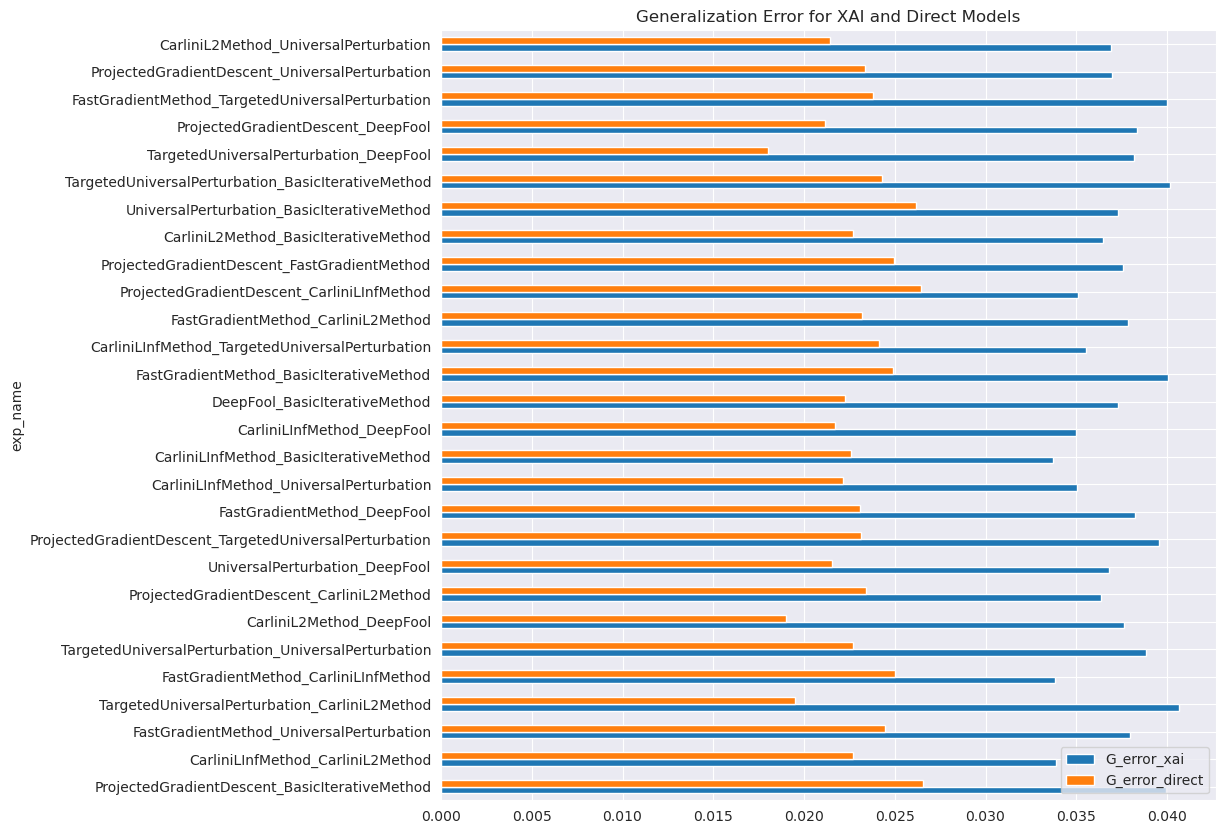

In [24]:
# merge the two dataframes gen_err_xai_df and gen_err_direct_df by the exp_name and do not change any other columns

gen_err_df = pd.merge(gen_err_xai_df, gen_err_direct_df, on='exp_name', suffixes=('_xai', '_direct'))
gen_err_df = gen_err_df.drop(['exp_type_xai', 'exp_type_direct'], axis=1)
gen_err_df.plot(x='exp_name', y=['G_error_xai', 'G_error_direct'], kind='barh', figsize=(10, 10), title='Generalization Error for XAI and Direct Models' )


## (Trying to replicate depending on the seed) Saving the full dataset (including the labels) to a separate file 

In [26]:
%%script --flase
# outside
## load the data
adv_data = load_all_adv_data(load_all_adv_data_dir)
# print the shape of all in adv_data
for key, value in adv_data.items():
    print(f"Attack: {key}, Shape: {value.shape}")

## put them in a data structure that can be used to create combinations
n_to_leave = 3
model_to_train=None

combos = combinations(adv_data, len(adv_data)-n_to_leave)
combos_ls = list(combos)
combos_and_left_out_ls = []
for combo in combos_ls:
    left_out_attacks=[]
    # Take the left out attack by comparing the two arrays adv_data.keys() and each combination created
    for x in list(adv_data.keys()):
        if x not in combo:
            left_out_attacks.append(x)
    combos_and_left_out_ls.append((tuple(left_out_attacks), combo))

## Iterate through each combination ---> results
i = 0
results_dicts_ls = []
unseen_data_dict = {}
for unseen_atk, combo in tqdm(combos_and_left_out_ls):
    # For multiple unseen attacks
    print(f"Experiment for Unseen attack: {unseen_atk} is starting ...")
    print("=====================================================")
    ##################################################################
    #### Direct adversarial detection model ####
    ##################################################################
    print("Direct part of the experiment is starting...")
    modification_text = f'direct_1ATK_{unseen_atk}'
    experiment_type='direct'
    # Extract the datasets from the combinations
    # Prepare the benign dataset
    # combine the datasets
    X_full, y_full, label_map = _dataset_combination(
                            # concatenate the adversarial data
                           *_concatenate_att_combo_data(adv_data, combo)
                            # get the benign data
                         , *_prep_benign_data()
                         )
    # prep unseen data
    X_unseen, y_test_unseen, unseen_label_map = prep_mult_unseen_data(adv_data , unseen_atk)
    unseen_X_test, unseen_original_y_test, unseen_y_test_bin, concat_labels= unseen_data_concat(X_unseen, y_test_unseen, unseen_label_map)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)
    
    # convert the labels to binary for generalizability test
    # Converting after the split to avoid losing the order of the attack type labels
    # This is the order of the labels 0 --> Benign, 1 --> Adversarial
    binary_classes=['Benign', 'Adversarial'] 
    y_train_bin = convert_labels_to_binary(y_train)
    y_test_bin = convert_labels_to_binary(y_test)
    # create a dictionary with unseen attack as the key and the data as the value
    unseen_data_dict["_".join(unseen_atk)]= {'X_unseen': unseen_X_test, 'y_test_unseen': unseen_original_y_test, 'y_test_unseen_bin': unseen_y_test_bin, 'label_map': unseen_label_map, 'concat_labels': concat_labels, 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    # save this dictionary as .npy in the data directory

save_adv_data(unseen_data_dict, "n_left_"+str(n_to_leave))

Couldn't find program: '--flase'


## the loop

In [27]:
if TDD_loop:
    # outside
    ## load the data
    adv_data = load_all_adv_data(load_all_adv_data_dir)
    # print the shape of all in adv_data
    for key, value in adv_data.items():
        print(f"Attack: {key}, Shape: {value.shape}")
    
    ## put them in a data structure that can be used to create combinations
    n_to_leave = 2
    model_to_train=None
    
    combos = combinations(adv_data, len(adv_data)-n_to_leave)
    combos_ls = list(combos)
    combos_and_left_out_ls = []
    for combo in combos_ls:
        left_out_attacks=[]
        # Take the left out attack by comparing the two arrays adv_data.keys() and each combination created
        for x in list(adv_data.keys()):
            if x not in combo:
                left_out_attacks.append(x)
        combos_and_left_out_ls.append((tuple(left_out_attacks), combo))
    
    ## Iterate through each combination ---> results
    i = 0
    results_dicts_ls = []
    # for unseen_atk, combo in tqdm(combos_and_left_out_ls):
    unseen_atk, combo = combos_and_left_out_ls[0]
    
    print(f"Experiment for Unseen attack: {unseen_atk} is starting ...")
    print("=====================================================")
    ##################################################################
    #### Direct adversarial detection model ####
    ##################################################################
    print("Direct part of the experiment is starting...")
    modification_text = f'direct_1ATK_{unseen_atk}'
    experiment_type='direct'
    # Extract the datasets from the combinations
    # Prepare the benign dataset
    # combine the datasets
    X_full, y_full, label_map = _dataset_combination(
                            # concatenate the adversarial data
                           *_concatenate_att_combo_data(adv_data, combo)
                            # get the benign data
                         , *_prep_benign_data()
                         )
    # prep unseen data
    X_unseen, y_test_unseen, unseen_classes = prep_unseen_data(adv_data , unseen_atk)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=50, stratify=y_full, shuffle=True)
    
    X_train, X_test, y_train, y_test = X_train[:500, :], X_test[:500, :], y_train[:500,:], y_test[:500, :]
    
    print("Adooooooooooooooooo")
    print("X_train shape: ", X_train.shape)
    print("X_test shape: ", X_test.shape)
    print("y_train shape: ", y_train.shape)
    print("y_test shape: ", y_test.shape)
    
    # convert the labels to binary for generalizability test
    # Converting after the split to avoid losing the order of the attack type labels
    # This is the order of the labels 0 --> Benign, 1 --> Adversarial
    binary_classes=['Benign', 'Adversarial'] 
    y_train_bin = convert_labels_to_binary(y_train)
    y_test_bin = convert_labels_to_binary(y_test)
    
    # Model creation
    model_to_train = ['xgboost']
    # add 'sklearn_mlp' to the models_to_train list to train the MLP model
    print("Training the direct model...")
    models_dict_direct = train_models(models_to_train=model_to_train, X_train=X_train, y_train_GT=y_train_bin, experiment_type=experiment_type, unseen_atk_name=unseen_atk)
    
    # Model evaluation
    print("Evaluating the direct model...")
    analysis_ls = model_analysis(models_dict=models_dict_direct
                                   , X_test=X_test
                                   , y_test_model=y_test_bin
                                   , y_original_test=y_test
                                   , unseen_X_test=X_unseen
                                   , unseen_y_test=y_test_unseen
                                   , unseen_labels_model=unseen_classes
                                   , modification_text=modification_text
                                   , label_map=label_map
                                   , labels_model=binary_classes
                                   , results_figs_dir=results_figs_dir
                                   , results_data_dir=results_data_dir
                                   )
    temp_analysis_ls = analysis_ls
    # Append the metadata. If you are modifying the analysis ls or it's dictionaries, you have to write a function to append stuff for the full all the dicts in it.
    results_ls = append_experiment_metadata(results_ls=analysis_ls
                                              , modification_text=modification_text
                                              , unseen_atk=unseen_atk
                                              , n_unseen=n_to_leave # use the length of unseen variable when using more attacks
                                              , n_train_atks=len(combo)
                                              , experiment_type='direct'
                                              )
    # Append direct results
    results_dicts_ls.append(results_ls)
    
    #### Generate explanations ####
    print("Generating Explanations for direct model...")
    xai_data_dict, direct_explainer = generate_explanations(X_train=X_train
                                          , X_test=X_test
                                          , X_unseen=X_unseen
                                          , models_dict=models_dict_direct
                                          , unseen_atk=unseen_atk
                                          , experiment_type=experiment_type
                                          )
    print("Explanations generated for direct model!")
    
    ##################################################################
    #### XAI based adversarial detection model ####
    ################################################################## 
    print("XAI part of the experiment is starting...")
    modification_text = f'xai_1ATK_{unseen_atk}'
    experiment_type='xai'
    
    # Reassigning the references
    X_train_xai = xai_data_dict[model_to_train[0]]['X_xai_train']
    X_test_xai = xai_data_dict[model_to_train[0]]['X_xai_test']
    X_unseen_xai = xai_data_dict[model_to_train[0]]['X_xai_unseen']
    ## model name
    model_to_train=['xgboost']
    
    # Train the model
    # Evaluate the model
    print("Training the xai model...")
    models_dict_xai = train_models(models_to_train=model_to_train, X_train=X_train_xai, y_train_GT=y_train_bin, experiment_type=experiment_type, unseen_atk_name=unseen_atk)
    
    # Model evaluation
    print("Evaluating the xai model...")
    analysis_ls = model_analysis(models_dict=models_dict_xai
                                   , X_test=X_test_xai
                                   , y_test_model=y_test_bin
                                   , y_original_test=y_test
                                   , unseen_X_test=X_unseen_xai
                                   , unseen_y_test=y_test_unseen
                                   , unseen_labels_model=unseen_classes
                                   , modification_text=modification_text
                                   , label_map=label_map
                                   , labels_model=binary_classes
                                   , results_figs_dir=results_figs_dir
                                   , results_data_dir=results_data_dir
                                   )
    
    # Append the metadata. If you are modifying the analysis ls or it's dictionaries, you have to write a function to append stuff for all the dicts in it.
    results_ls = append_experiment_metadata(results_ls=analysis_ls
                                              , modification_text=modification_text
                                              , unseen_atk=unseen_atk
                                              , n_unseen=n_to_leave # use the length of unseen variable when using more attacks
                                              , n_train_atks=len(combo)
                                              , experiment_type=experiment_type
                                              )
    results_dicts_ls.append(results_ls)
    
    #### Generate explanations ####
    print("Generating Explanations for xai model...")
    generate_explanations(X_train=X_train_xai
                          , X_test=X_test_xai
                          , X_unseen=X_unseen_xai
                          , models_dict=models_dict_xai
                          , unseen_atk=unseen_atk
                          , experiment_type=experiment_type
                          )
    print("Explanations generated for XAI model!")
    print("=====================================================")
    
        
    ##################################################################
    #### Ensemble method ####
    ##################################################################
    print("Ensemble part of the experiment is starting...")
    for ensemble_method in [AverageEnsembleModel, StackedEnsembleModel, StackedXDirectEnsembleModel, StackedXExplEnsembleModel]:
        # remove the unnecessary parts of the class name to make it more readable
        class_name = str(ensemble_method).split('.')[-1].split('\'')[0].replace("EnsembleModel", "")
        modification_text = f'{class_name}_1ATK_{unseen_atk}'
        experiment_type=f"ensemble_{class_name}"
        
        print(f"{experiment_type} is building...")
        
        ensemble_model = ensemble_method(models_dict_direct[list(models_dict_direct.keys())[0]], models_dict_xai[list(models_dict_xai.keys())[0]], direct_explainer)
        
        print(f"{experiment_type} is fitting...")
        if ensemble_method == AverageEnsembleModel:
            ensemble_model.fit(X_train, X_train_xai, y_train_bin, model_type='weighted')
        else:
            ensemble_model.fit(X_train, X_train_xai, y_train_bin, model_type='random_forest', use_proba=True)
        
        # Model evaluation
        print(f"Evaluating the {experiment_type} model...")
        analysis_ls = model_analysis(models_dict={'ensemble': ensemble_model}
                                       , X_test=X_test
                                       , y_test_model=y_test_bin
                                       , y_original_test=y_test
                                       , unseen_X_test=X_unseen
                                       , unseen_y_test=y_test_unseen
                                       , unseen_labels_model=unseen_classes
                                       , modification_text=modification_text
                                       , label_map=label_map
                                       , labels_model=binary_classes
                                       , results_figs_dir=results_figs_dir
                                       , results_data_dir=results_data_dir
                                       )
        # Append the metadata. If you are modifying the analysis ls or it's dictionaries, you have to write a function to append stuff for all the dicts in it.
        results_ls = append_experiment_metadata(results_ls=analysis_ls
                                                  , modification_text=modification_text
                                                  , unseen_atk=unseen_atk
                                                  , n_unseen=n_to_leave # use the length of unseen variable when using more attacks
                                                  , n_train_atks=len(combo)
                                                  , experiment_type=experiment_type
                                                  )
        results_dicts_ls.append(results_ls)
        print("Adoooooooooooooooooooo")
        print(analysis_ls[0]["accuracy"])
        print(f"{experiment_type} run complete for the unseen attack: ", unseen_atk)
        break
print("=====================================================")

# Analysis of the results

## Intermediate runtime results analysis


In [97]:
if RUNTIME_VIZ:   
    # read all the files in results_data_dir 
    results_files = os.listdir(results_data_dir)
    # filter out the csv files
    results_csv_files = [f for f in results_files if f.endswith('.csv')]
    model_type_ls = []
    unseen_attack_ls = []
    for filename in results_csv_files:
        model_type_ls.append(filename.split('_')[2])
        unseen_attack_ls.append(filename.split('_')[4])
    # combine all the files into a single dataframe with their names in a column 
    results_df = pd.concat([pd.read_csv(os.path.join(results_data_dir, f)) for f in results_csv_files])
    # add the column named 'model_type' and 'unseen_attack'
    results_df['model_type'] = model_type_ls
    results_df['unseen_attack'] = unseen_attack_ls
    # filtered_results = results_df[]
    # filtered_results
    # filter out the following columns from results_df 'model_type', 'unseen_attack', 'unseen_accuracy', 'Benign_precision', 'Adversarial_precision', 'accuracy'
    filtered_results = results_df[['unseen_attack', 'model_type', 'unseen_accuracy', 'accuracy']]
    # delete the index column from the dataframe
    filtered_results.reset_index(drop=True, inplace=True)
    # delete the unnamed column from the dataframe
    # filtered_results.drop(columns='', inplace=True)
    # sort the dataframe model_type and unseen_attack
    filtered_results.sort_values(by=['unseen_attack', 'model_type'], inplace=True)
    filtered_results

## Explanation visualization

In [94]:
# Read all the files in a directory
folder_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_09-08-24/Explanations/"
# List all files in the provided folder


def parse_experiment_types(text_list):
    experiment_types=[]
    for each_file in text_list:
        experiment_types.append(each_file.split(',')[0].split('_')[0])
    return np.unique(experiment_types)

def load_explanations(explanations_path):
    files = os.listdir(explanations_path)
    # Filter out the .npy files
    npy_files = [f for f in files if f.endswith('.npy')]
    npy_data = []
    
    for npy_file in npy_files:
        file_path = os.path.join(explanations_path, npy_file)
        data = np.load(file_path, allow_pickle=True)
        npy_data.append(data)
        
    # dict_data = {{'xai': {}, 'direct':{}} for file in npy_files}
    dict_data={}
    # Parse the experiment types from the file names
    exp_types = parse_experiment_types(npy_files)
    
    for each_file in npy_files:
        dict_data[each_file.split(',')[0].split('_')[1]] = dict(zip(exp_types, [{} for _ in range(len(exp_types))]))
    
    for each_file, each_data in zip(npy_files, npy_data):
        for each_exp_type in exp_types:
            if each_file.split(',')[0].split('_')[0] == each_exp_type:
                dict_data[each_file.split(',')[0].split('_')[1]][each_exp_type] = each_data.item()

    return dict_data

In [99]:
if GENERATE_EXPL_PLOTS:

    loaded_explanations = load_explanations(explanations_path=folder_path)
    
    # Plot the summary plots
    from shap import Explanation
    
    for unseen_atk, value in tqdm(loaded_explanations.items()):
        for exp_type, exp_data in value.items():
            for data_type, data in exp_data.items():
                for max_display_val in [5, 15]:
                    expl_obj = Explanation(data['values'], data['base_values'], data['data'])
                    shap.summary_plot(expl_obj, plot_type='violin', show=False, max_display=max_display_val)
                    plt.title(f"{data_type}_{exp_type}_{unseen_atk}_shap_summary_plot")
                    plt.savefig(os.path.join(results_figs_dir, f"{max_display_val}_{data_type}_{exp_type}_{unseen_atk}_shap_summary_plot_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)
                    plt.close()
    
if GENERATE_EXPL_PLOTS:
    exit()

## Performance evaluation

In [28]:
# plot a double bar graph for the unseen_accuracy
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Load the results dataframe
results_load_date = "23-08-24"
# load the results dataframe from the results_data_dir
selection_time='03-59-42'
glob_path = os.path.join(path_base+results_load_date, "Observations",  "LOOP*.csv")
final_result_files = glob.glob(glob_path)
# select the path ending with 'selection_time' out of the list of strings from final_result_files
final_result_file = [f for f in final_result_files if f.endswith(selection_time+'.csv')]
print("All the LOOP files")
pprint(final_result_files)
print("Selected LOOP file")
pprint(final_result_file)
results_df = pd.read_csv(final_result_file[0])

results_df

All the LOOP files
["/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_23-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_03-59-42.csv",
 "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_23-08-24/Observations/LOOP_end_results_train_diff_models_['xgboost']_1ATK_19-42-06.csv"]
Selected LOOP file
["/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_23-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_03-59-42.csv"]


,Unnamed: 0,Benign_precision,Benign_recall,Benign_f1-score,Benign_support,Adversarial_precision,Adversarial_recall,Adversarial_f1-score,Adversarial_support,accuracy,...,unseen_tn,unseen_fp,unseen_fn,experiment_time,modification_text,unseen_atk,n_unseen,n_train_atks,experiment_type,cls_BasicIterativeMethod
0,0,0.916651,0.973191,0.944075,15256.0,0.971429,0.911510,0.940516,15256.0,0.942351,...,0,0,0,2024-08-23-20:47:17,direct_1ATK_BasicIterativeMethod,BasicIterativeMethod,1,7,direct,NaN
1,1,0.953531,0.963031,0.958257,15256.0,0.962659,0.953068,0.957839,15256.0,0.958049,...,0,0,0,2024-08-23-20:57:48,xai_1ATK_BasicIterativeMethod,BasicIterativeMethod,1,7,xai,NaN
2,2,0.953531,0.963031,0.958257,15256.0,0.962659,0.953068,0.957839,15256.0,0.958049,...,0,0,0,2024-08-23-21:10:10,Stacked_linear_regression_1ATK_BasicIterativeM...,BasicIterativeMethod,1,7,ensemble_Stacked_linear_regression,NaN
3,3,0.953531,0.963031,0.958257,15256.0,0.962659,0.953068,0.957839,15256.0,0.958049,...,0,0,0,2024-08-23-21:12:58,Stacked_random_forest_1ATK_BasicIterativeMethod,BasicIterativeMethod,1,7,ensemble_Stacked_random_forest,NaN
4,4,0.953531,0.963031,0.958257,15256.0,0.962659,0.953068,0.957839,15256.0,0.958049,...,0,0,0,2024-08-23-21:15:38,Stacked_xgboost_1ATK_BasicIterativeMethod,BasicIterativeMethod,1,7,ensemble_Stacked_xgboost,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,0.955836,0.964670,0.960232,15256.0,0.964340,0.955427,0.959863,15256.0,0.960049,...,0,0,0,2024-08-24-03:43:56,StackedXDirect_random_forest_1ATK_ProjectedGra...,ProjectedGradientDescent,1,7,ensemble_StackedXDirect_random_forest,0.0
84,84,0.953359,0.964670,0.958981,15256.0,0.964245,0.952805,0.958491,15256.0,0.958738,...,0,0,0,2024-08-24-03:47:06,StackedXDirect_xgboost_1ATK_ProjectedGradientD...,ProjectedGradientDescent,1,7,ensemble_StackedXDirect_xgboost,0.0
85,85,0.953174,0.964670,0.958887,15256.0,0.964238,0.952609,0.958388,15256.0,0.958639,...,0,0,0,2024-08-24-03:49:42,StackedXExpl_linear_regression_1ATK_ProjectedG...,ProjectedGradientDescent,1,7,ensemble_StackedXExpl_linear_regression,0.0
86,86,0.957203,0.964670,0.960922,15256.0,0.964392,0.956869,0.960616,15256.0,0.960770,...,0,0,0,2024-08-24-03:56:36,StackedXExpl_random_forest_1ATK_ProjectedGradi...,ProjectedGradientDescent,1,7,ensemble_StackedXExpl_random_forest,0.0


### Accuracy calculations


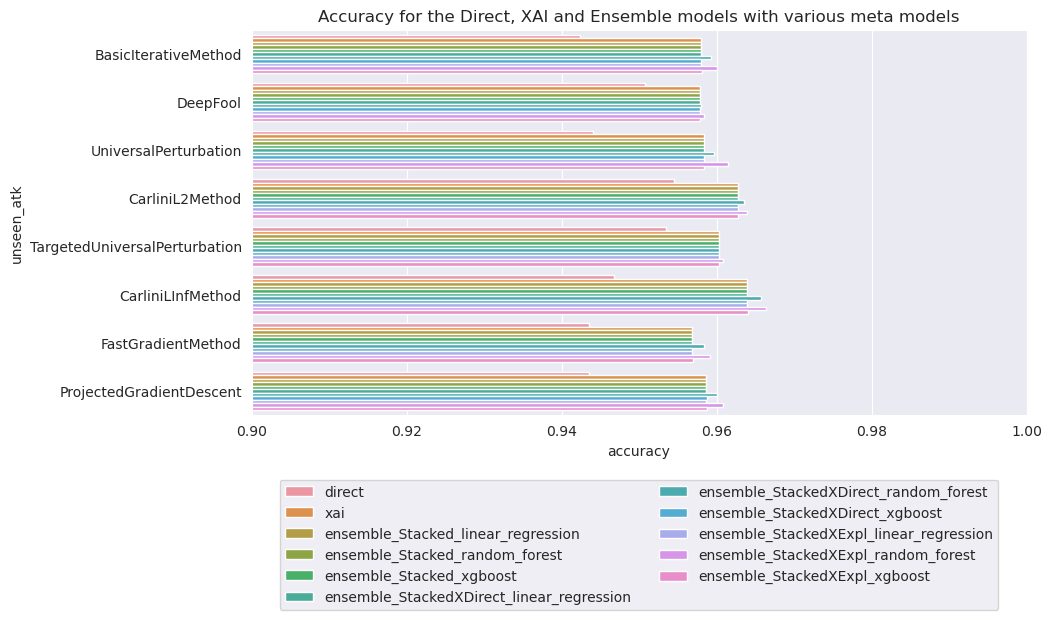

In [105]:
# plot a graph for accuracy and unseen_accuracy for the direct and xai models
# Plot the unseen accuracy
sns.set_style(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.barplot(x='accuracy', y='unseen_atk', hue='experiment_type', data=results_df)
plt.title("Accuracy for the Direct, XAI and Ensemble models with various meta models")
plt.legend(bbox_to_anchor=(0.5, -0.15),ncol=2, loc='upper center')
plt.xlim(0.90, 1)
plt.savefig(os.path.join(results_figs_dir, f"accuracy_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

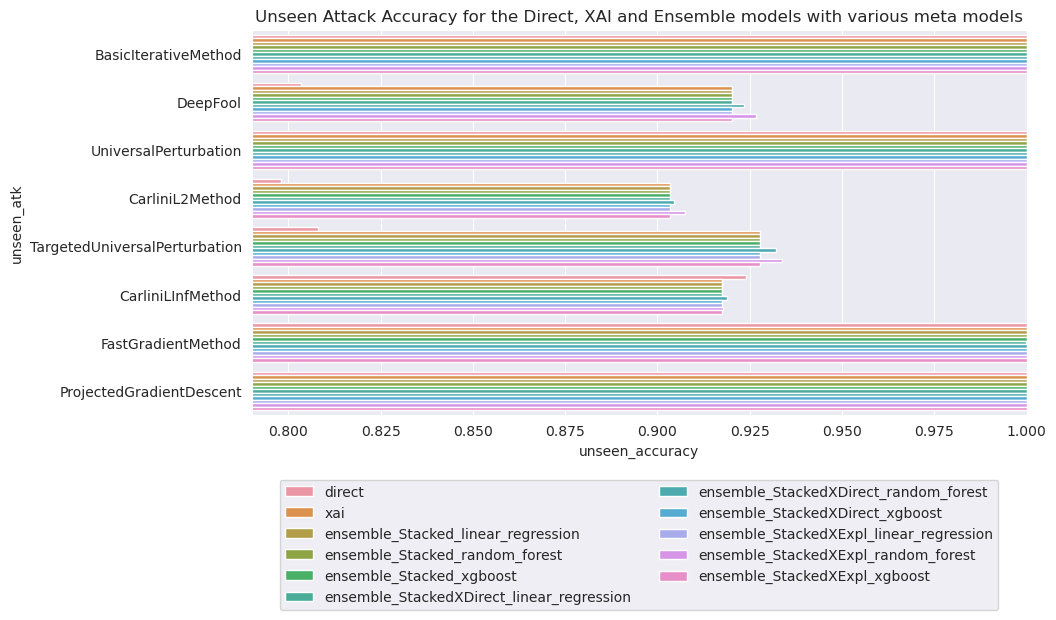

In [106]:

sns.set_style(style="darkgrid")
# Plot the unseen accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x='unseen_accuracy', y='unseen_atk', hue='experiment_type', data=results_df)
# plt.xticks(rotation=90)
plt.title("Unseen Attack Accuracy for the Direct, XAI and Ensemble models with various meta models")
# change legend position
plt.legend(bbox_to_anchor=(0.5, -0.15),ncol=2, loc='upper center')
# shorten the x axis length
plt.xlim(0.79, 1)
# Save the plot
plt.savefig(os.path.join(results_figs_dir, f"unseen_accuracy_attack_wise_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

### unseen accuracy highest/lowest models 

In [107]:
# results_df[['experiment_type', 'accuracy', 'unseen_accuracy']]
# from results_df, filter down the experiment_type for the highest unseen_accuracy grouped by the unseen_atk
max_accuracy_df = results_df.loc[results_df.groupby('unseen_atk')['accuracy'].idxmax()]

# Extract the 'experiment_type' from these rows
experiment_types = max_accuracy_df[['unseen_atk', 'experiment_type', 'accuracy']]
experiment_types

,unseen_atk,experiment_type,accuracy
9,BasicIterativeMethod,ensemble_StackedXExpl_random_forest,0.960114
42,CarliniL2Method,ensemble_StackedXExpl_random_forest,0.963949
64,CarliniLInfMethod,ensemble_StackedXExpl_random_forest,0.966407
20,DeepFool,ensemble_StackedXExpl_random_forest,0.958443
75,FastGradientMethod,ensemble_StackedXExpl_random_forest,0.959196
86,ProjectedGradientDescent,ensemble_StackedXExpl_random_forest,0.960770
53,TargetedUniversalPerturbation,ensemble_StackedXExpl_random_forest,0.960868
31,UniversalPerturbation,ensemble_StackedXExpl_random_forest,0.961458


In [175]:
# from the resulting dataframe, drop the rows with "BasicIterativeMethod, UniversalPerturbation, FastGradientMethod, ProjectedGradientDescent" in the "unseen_atk" column
# Because these attacks have 100 percent accuracy for all methods when unseen.
methods_to_drop = ["BasicIterativeMethod", "UniversalPerturbation", "FastGradientMethod", "ProjectedGradientDescent"]

# Drop rows where 'unseen_atk' is in the list of methods_to_drop
filtered_experiment_types = experiment_types[~experiment_types['unseen_atk'].isin(methods_to_drop)]
filtered_experiment_types

,unseen_atk,experiment_type,unseen_accuracy
33,CarliniL2Method,direct,0.797926
56,CarliniLInfMethod,xai,0.917500
11,DeepFool,direct,0.803524
44,TargetedUniversalPerturbation,direct,0.807929


### With two unseen attacks

In [41]:
# Load the results dataframe
results_load_date = "27-08-24"
# load the results dataframe from the results_data_dir
selection_time='00-41-42'
glob_path = os.path.join(path_base+results_load_date, "Observations",  "LOOP*.csv")
final_result_files = glob.glob(glob_path)
# select the path ending with 'selection_time' out of the list of strings from final_result_files
final_result_file = [f for f in final_result_files if f.endswith(selection_time+'.csv')]
pprint(final_result_files)
pprint(final_result_file)
results_df = pd.read_csv(final_result_file[0])

results_df

["/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_27-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_00-41-42.csv"]
["/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_27-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_00-41-42.csv"]


,Unnamed: 0,Benign_precision,Benign_recall,Benign_f1-score,Benign_support,Adversarial_precision,Adversarial_recall,Adversarial_f1-score,Adversarial_support,accuracy,...,unseen_size_nft_TargetedUniversalPerturbation,unseen_cls_CarliniLInfMethod,unseen_size_len_CarliniLInfMethod,unseen_size_nft_CarliniLInfMethod,unseen_cls_FastGradientMethod,unseen_size_len_FastGradientMethod,unseen_size_nft_FastGradientMethod,unseen_cls_ProjectedGradientDescent,unseen_size_len_ProjectedGradientDescent,unseen_size_nft_ProjectedGradientDescent
0,0,0.913649,0.978206,0.944826,13077.0,0.976547,0.907541,0.940780,13076.0,0.942875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.941673,0.964212,0.952809,13077.0,0.963332,0.940272,0.951662,13076.0,0.952243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.942236,0.964212,0.953097,13077.0,0.963354,0.940884,0.951987,13076.0,0.952548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.900043,0.965359,0.931557,13077.0,0.962645,0.892781,0.926398,13076.0,0.929071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.941092,0.957788,0.949367,13077.0,0.957023,0.940043,0.948457,13076.0,0.948916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,0.952953,0.958783,0.955859,13077.0,0.958526,0.952661,0.955585,13076.0,0.955722,...,NaN,861.0,10897.0,256.0,NaN,NaN,NaN,0.0,10897.0,256.0
80,80,0.953243,0.958783,0.956005,13077.0,0.958538,0.952967,0.955745,13076.0,0.955875,...,NaN,861.0,10897.0,256.0,NaN,NaN,NaN,0.0,10897.0,256.0
81,81,0.902064,0.969183,0.934420,13077.0,0.966702,0.894769,0.929346,13076.0,0.931977,...,NaN,NaN,NaN,NaN,0.0,10897.0,256.0,0.0,10897.0,256.0
82,82,0.941623,0.957177,0.949336,13077.0,0.956454,0.940655,0.948489,13076.0,0.948916,...,NaN,NaN,NaN,NaN,0.0,10897.0,256.0,0.0,10897.0,256.0


In [42]:
import string

ditionary_ref = {"DeepFool":"DF"
                 ,"BasicIterativeMethod":"BIM"
                 ,"CarliniL2Method":"CWL2"
                 ,"TargetedUniversalPerturbation":"TUP"
                 ,"ProjectedGradientDescent":"PGD"
                 ,"UniversalPerturbation":"UAP"
                 ,"FastGradientMethod":"FGSM"
                 ,"CarliniLInfMethod":"CWLI"
                 }

def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Replace words using dictionary
    words = text.split()
    words = [ditionary_ref.get(word, word) for word in words]

    return ", ".join(words)

# Apply function to the DataFrame column
results_df['unseen_atk'] = results_df['unseen_atk'].apply(clean_text)

results_df

,Unnamed: 0,Benign_precision,Benign_recall,Benign_f1-score,Benign_support,Adversarial_precision,Adversarial_recall,Adversarial_f1-score,Adversarial_support,accuracy,...,unseen_size_nft_TargetedUniversalPerturbation,unseen_cls_CarliniLInfMethod,unseen_size_len_CarliniLInfMethod,unseen_size_nft_CarliniLInfMethod,unseen_cls_FastGradientMethod,unseen_size_len_FastGradientMethod,unseen_size_nft_FastGradientMethod,unseen_cls_ProjectedGradientDescent,unseen_size_len_ProjectedGradientDescent,unseen_size_nft_ProjectedGradientDescent
0,0,0.913649,0.978206,0.944826,13077.0,0.976547,0.907541,0.940780,13076.0,0.942875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.941673,0.964212,0.952809,13077.0,0.963332,0.940272,0.951662,13076.0,0.952243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.942236,0.964212,0.953097,13077.0,0.963354,0.940884,0.951987,13076.0,0.952548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.900043,0.965359,0.931557,13077.0,0.962645,0.892781,0.926398,13076.0,0.929071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.941092,0.957788,0.949367,13077.0,0.957023,0.940043,0.948457,13076.0,0.948916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,0.952953,0.958783,0.955859,13077.0,0.958526,0.952661,0.955585,13076.0,0.955722,...,NaN,861.0,10897.0,256.0,NaN,NaN,NaN,0.0,10897.0,256.0
80,80,0.953243,0.958783,0.956005,13077.0,0.958538,0.952967,0.955745,13076.0,0.955875,...,NaN,861.0,10897.0,256.0,NaN,NaN,NaN,0.0,10897.0,256.0
81,81,0.902064,0.969183,0.934420,13077.0,0.966702,0.894769,0.929346,13076.0,0.931977,...,NaN,NaN,NaN,NaN,0.0,10897.0,256.0,0.0,10897.0,256.0
82,82,0.941623,0.957177,0.949336,13077.0,0.956454,0.940655,0.948489,13076.0,0.948916,...,NaN,NaN,NaN,NaN,0.0,10897.0,256.0,0.0,10897.0,256.0


### Accuracy calculations

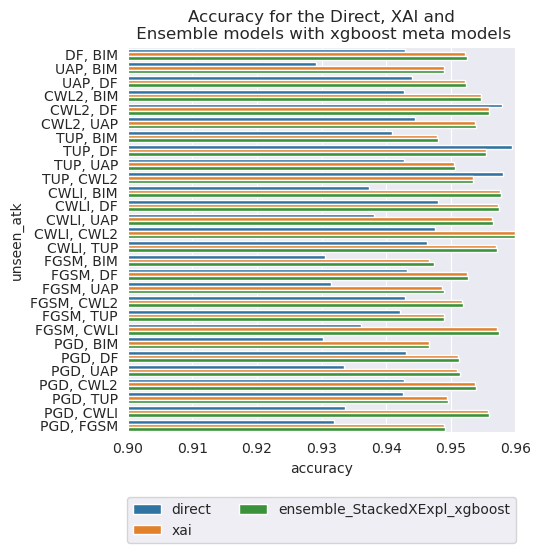

In [43]:
# plot a graph for accuracy and unseen_accuracy for the direct and xai models
# Plot the unseen accuracy
sns.set_style(style="darkgrid")
plt.figure(figsize=(5, 5))
sns.barplot(x='accuracy', y='unseen_atk', hue='experiment_type', data=results_df)
plt.title("Accuracy for the Direct, XAI and\n Ensemble models with xgboost meta models")
plt.legend(bbox_to_anchor=(0.5, -0.15),ncol=2, loc='upper center')
plt.xlim(0.90, 0.96)
plt.savefig(os.path.join(results_figs_dir, f"accuracy_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

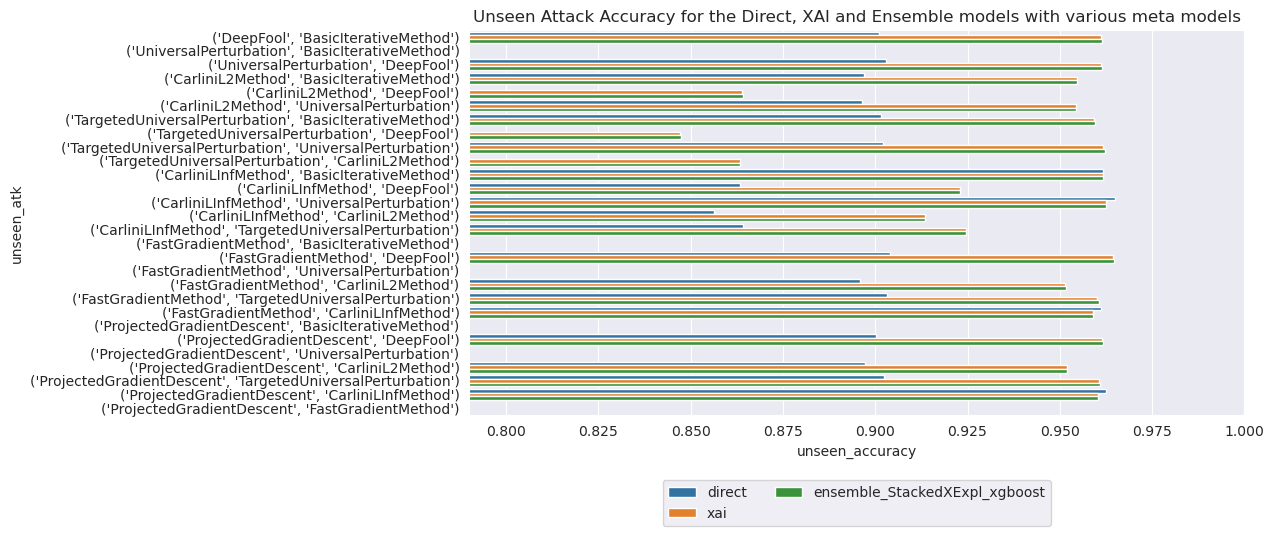

In [191]:

sns.set_style(style="darkgrid")
# Plot the unseen accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x='unseen_accuracy', y='unseen_atk', hue='experiment_type', data=results_df)
# plt.xticks(rotation=90)
plt.title("Unseen Attack Accuracy for the Direct, XAI and Ensemble models with various meta models")
# change legend position
plt.legend(bbox_to_anchor=(0.5, -0.15),ncol=2, loc='upper center')
# shorten the x axis length
plt.xlim(0.79, 1)
# Save the plot
plt.savefig(os.path.join(results_figs_dir, f"unseen_accuracy_attack_wise_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

In [189]:
# results_df[['experiment_type', 'accuracy', 'unseen_accuracy']]
# from results_df, filter down the experiment_type for the highest unseen_accuracy grouped by the unseen_atk
max_accuracy_df = results_df.loc[results_df.groupby('unseen_atk')['unseen_accuracy'].idxmax()]

# Extract the 'experiment_type' from these rows
experiment_types = max_accuracy_df[['unseen_atk', 'experiment_type', 'unseen_accuracy']]
experiment_types

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError


KeyError: '[nan] not in index'

In [ ]:
# from the resulting dataframe, drop the rows with "BasicIterativeMethod, UniversalPerturbation, FastGradientMethod, ProjectedGradientDescent" in the "unseen_atk" column
# Because these attacks have 100 percent accuracy for all methods when unseen.
methods_to_drop = ["BasicIterativeMethod", "UniversalPerturbation", "FastGradientMethod", "ProjectedGradientDescent"]

# Drop rows where 'unseen_atk' is in the list of methods_to_drop
filtered_experiment_types = experiment_types[~experiment_types['unseen_atk'].isin(methods_to_drop)]
filtered_experiment_types

### Different number of unseen attacks

In [63]:
one_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_23-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_03-59-42.csv"
two_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_27-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_00-41-42.csv"
three_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_28-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_10-42-08.csv"
four_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_29-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_10-52-23.csv"
five_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_31-08-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_17-20-55.csv"
six_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_02-09-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_15-46-24.csv"
seven_unseen_path = "/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_02-09-24/Observations/LOOP_end_results_train_ensembles_['xgboost']_1ATK_19-10-51.csv"

# Load all the above files to dataframes
one_unseen_df = pd.read_csv(one_unseen_path)
two_unseen_df = pd.read_csv(two_unseen_path)
three_unseen_df = pd.read_csv(three_unseen_path)
four_unseen_df = pd.read_csv(four_unseen_path)
five_unseen_df = pd.read_csv(five_unseen_path)
six_unseen_df = pd.read_csv(six_unseen_path)
seven_unseen_df = pd.read_csv(seven_unseen_path)

# Append all the dataframe into a single dataframe
results_df = pd.concat([one_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]], 
                        two_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]],
                        three_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]],
                        four_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]],
                        five_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]],
                        six_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]],
                        seven_unseen_df[["experiment_type", "accuracy", "unseen_atk", "unseen_accuracy", "n_unseen"]]])

# group the results by the n_unseen and get the average accuracy and unseen_accuracy where experiment_type is direct
filtered_df = results_df[results_df['experiment_type'] == 'xai']

# Group by 'n_unseen' and calculate the average of 'accuracy' and 'unseen_accuracy'
grouped_df = filtered_df.groupby('n_unseen')[['accuracy', 'unseen_accuracy']].mean()
# results_df.groupby('n_unseen')[['accuracy', 'unseen_accuracy']].mean()
grouped_df.mean()

accuracy           0.960289
unseen_accuracy    0.896298
dtype: float64

In [9]:
results_df

,experiment_type,accuracy,unseen_atk,unseen_accuracy,n_unseen
0,direct,0.942351,BasicIterativeMethod,1.000000,1
1,xai,0.958049,BasicIterativeMethod,1.000000,1
2,ensemble_Stacked_linear_regression,0.958049,BasicIterativeMethod,1.000000,1
3,ensemble_Stacked_random_forest,0.958049,BasicIterativeMethod,1.000000,1
4,ensemble_Stacked_xgboost,0.958049,BasicIterativeMethod,1.000000,1
...,...,...,...,...,...
19,xai,0.948153,"('ProjectedGradientDescent', 'FastGradientMeth...",0.994664,7
20,ensemble_StackedXExpl_xgboost,0.948153,"('ProjectedGradientDescent', 'FastGradientMeth...",0.994664,7
21,direct,0.999771,"('ProjectedGradientDescent', 'FastGradientMeth...",0.714456,7
22,xai,0.999771,"('ProjectedGradientDescent', 'FastGradientMeth...",0.694424,7


In [ ]:
# group the results by the n_unseen and get the average accuracy and unseen_accuracy where experiment_type is direct
filtered_df = results_df[results_df['experiment_type'] == 'direct']
filtered_df.reset_index(inplace=True)

uns1 = filtered_df.groupby('n_unseen')[['accuracy', 'unseen_accuracy']]

In [ ]:
filtered_df

In [71]:
# group the results by the n_unseen and get the average accuracy and unseen_accuracy where experiment_type is direct
filtered_df = results_df[results_df['experiment_type'] == 'xai']

uns2 = filtered_df.groupby('n_unseen')[['accuracy', 'unseen_accuracy']].mean()
uns2

,accuracy,unseen_accuracy
n_unseen,,
1,0.959590,0.958590
2,0.952706,0.940075
3,0.945951,0.937449
4,0.952301,0.923185
5,0.960862,0.899684
6,0.969939,0.866216
7,0.980672,0.748889


/home/spatial01/anaconda3/envs/netslab_lime_defense/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spatial01/anaconda3/envs/netslab_lime_defense/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spatial01/anaconda3/envs/netslab_lime_defense/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spatial01/anaconda3/envs/netslab_lime_defense/lib/python3.9/site-packages/seaborn/_ol

Text(0.5, 1.0, 'Unseen Attack Accuracy for the Direct and XAI models for different number of types')

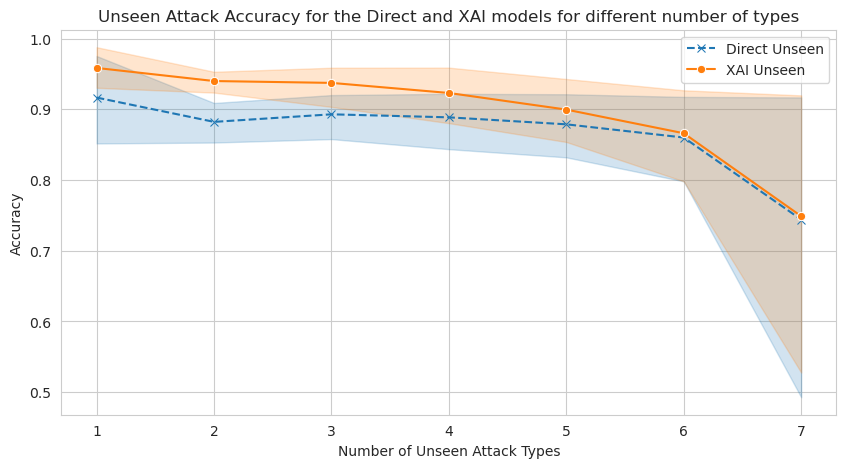

In [79]:
# plot line plot
import seaborn as sns

filtered_df_direct = results_df[results_df['experiment_type'] == 'direct']
filtered_df_direct.reset_index(inplace=True)

filtered_df_xai = results_df[results_df['experiment_type'] == 'xai']
filtered_df_xai.reset_index(inplace=True)

sns.set_style(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.lineplot(data=filtered_df_direct, x='n_unseen', y='unseen_accuracy', label='Direct Unseen',  marker="x", markeredgecolor="C0", markerfacecolor="C0", linestyle='--')
sns.lineplot(data=filtered_df_xai, x='n_unseen', y='unseen_accuracy', label='XAI Unseen',  marker="o")


plt.ylabel("Accuracy")
plt.xlabel("Number of Unseen Attack Types")
plt.title("Unseen Attack Accuracy for the Direct and XAI models for different number of types")
# plt.savefig(os.path.join(results_figs_dir, f"unseen_accuracy_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

In [53]:
# plot a graph for accuracy and unseen_accuracy for the direct and xai models
# Plot the unseen accuracy
sns.set_style(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.barplot(x='n_unseen', y='unseen_accuracy', data=uns1)
plt.title("Accuracy for the Direct, XAI and Ensemble models with various meta models")
plt.legend(bbox_to_anchor=(0.5, -0.15),ncol=2, loc='upper center')
plt.xlim(0.90, 1)
plt.savefig(os.path.join(results_figs_dir, f"accuracy_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

ValueError: Could not interpret input 'n_unseen'

<Figure size 1000x500 with 0 Axes>

# Number of records per each misclassified attack type

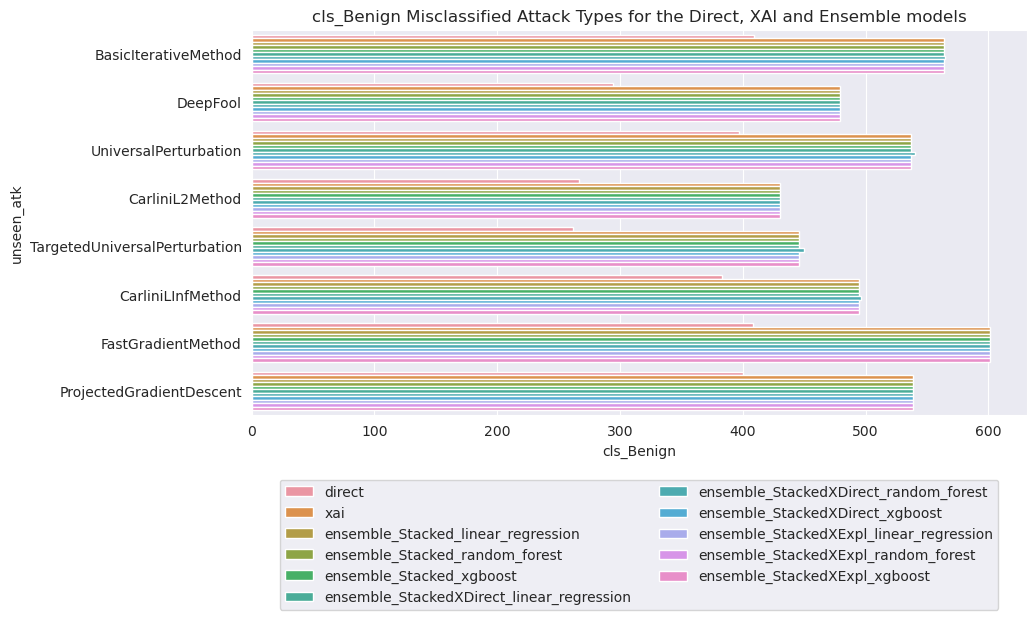

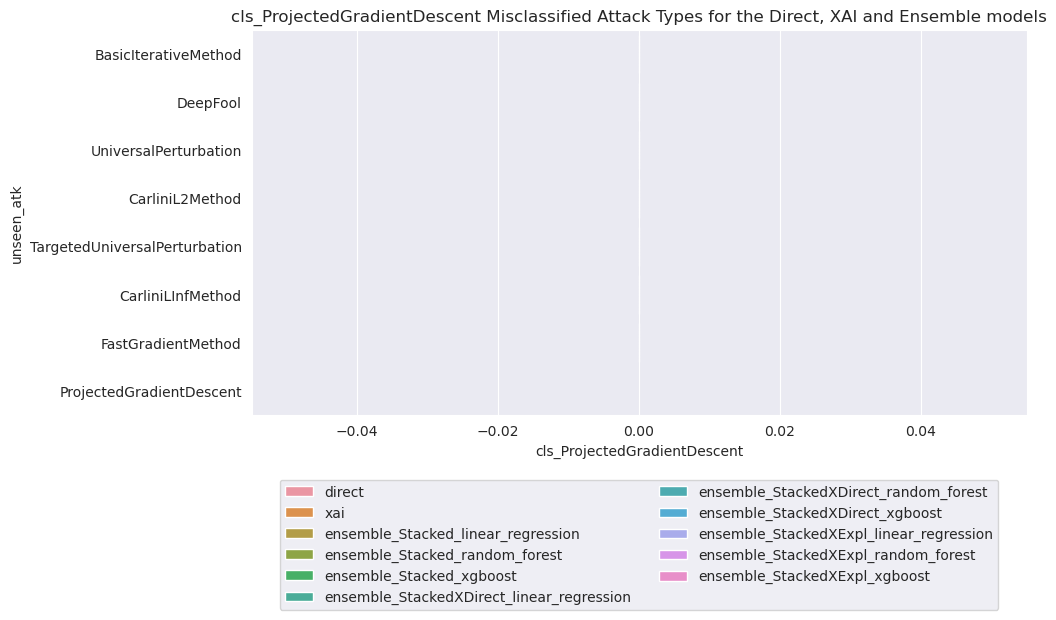

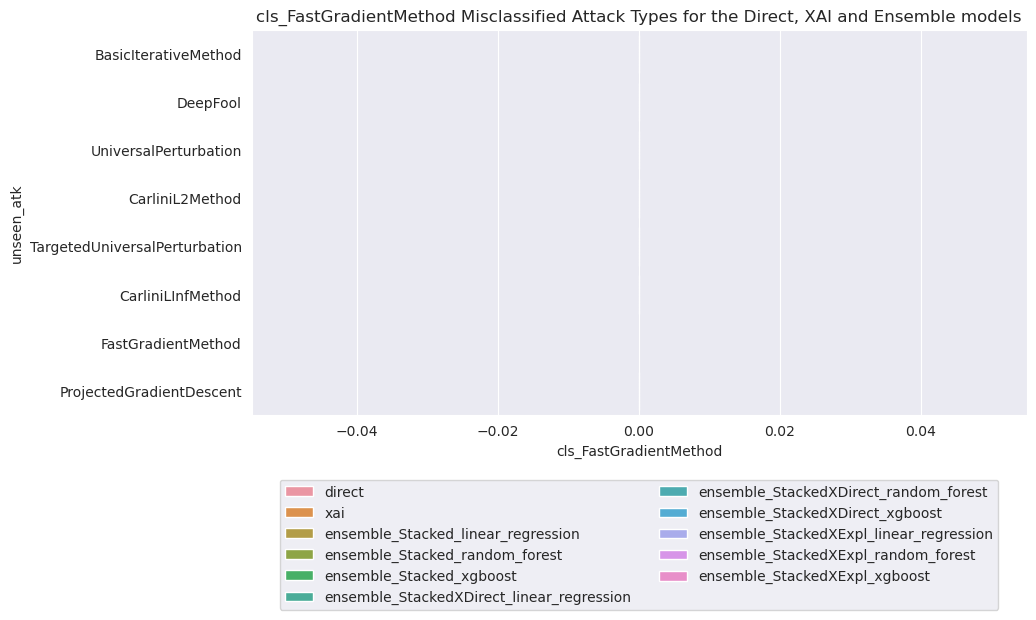

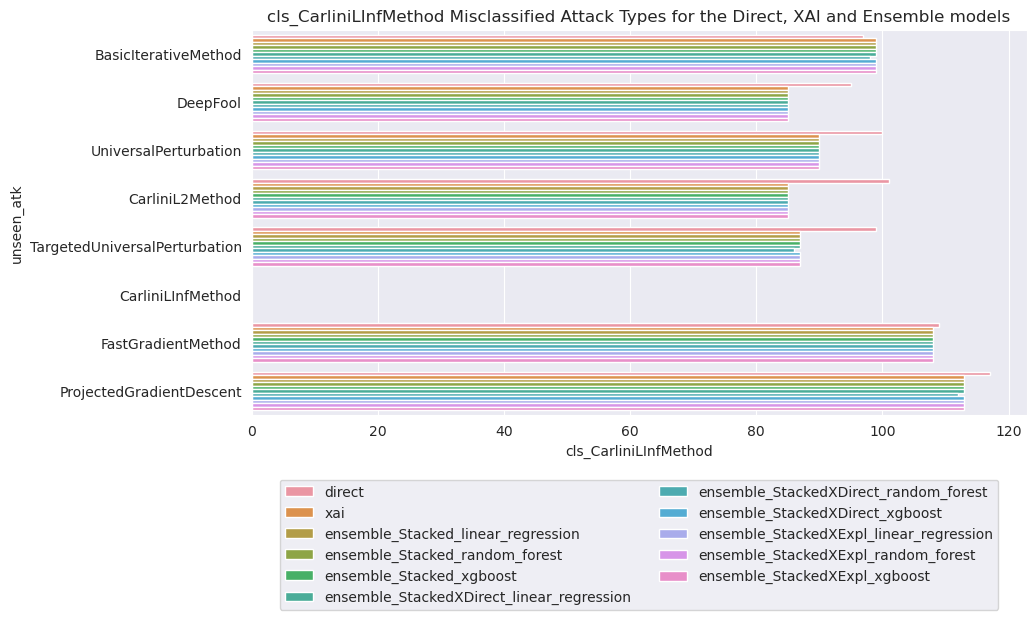

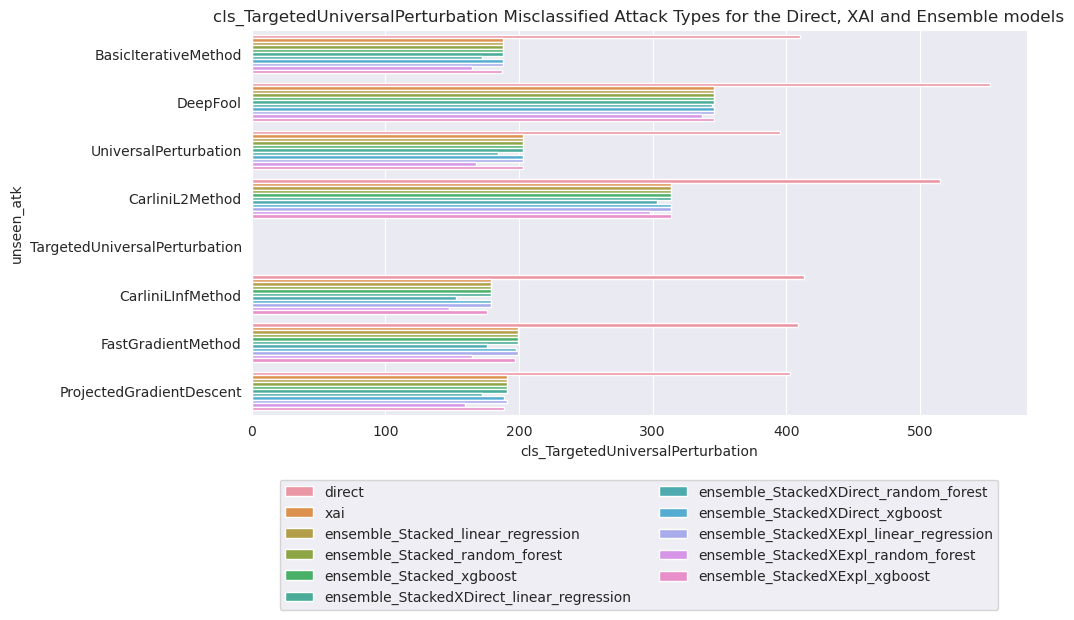

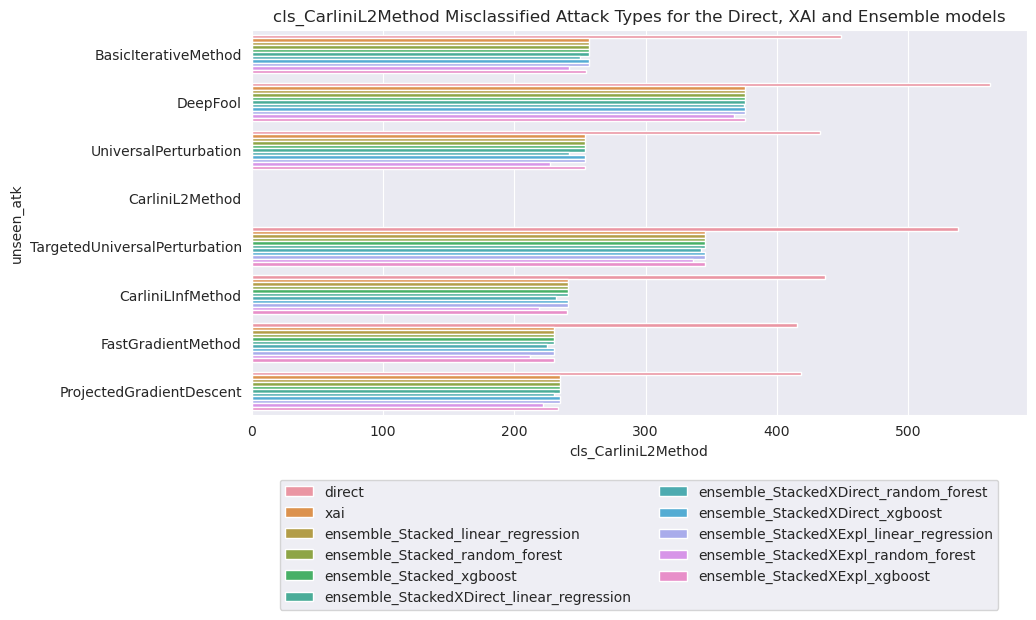

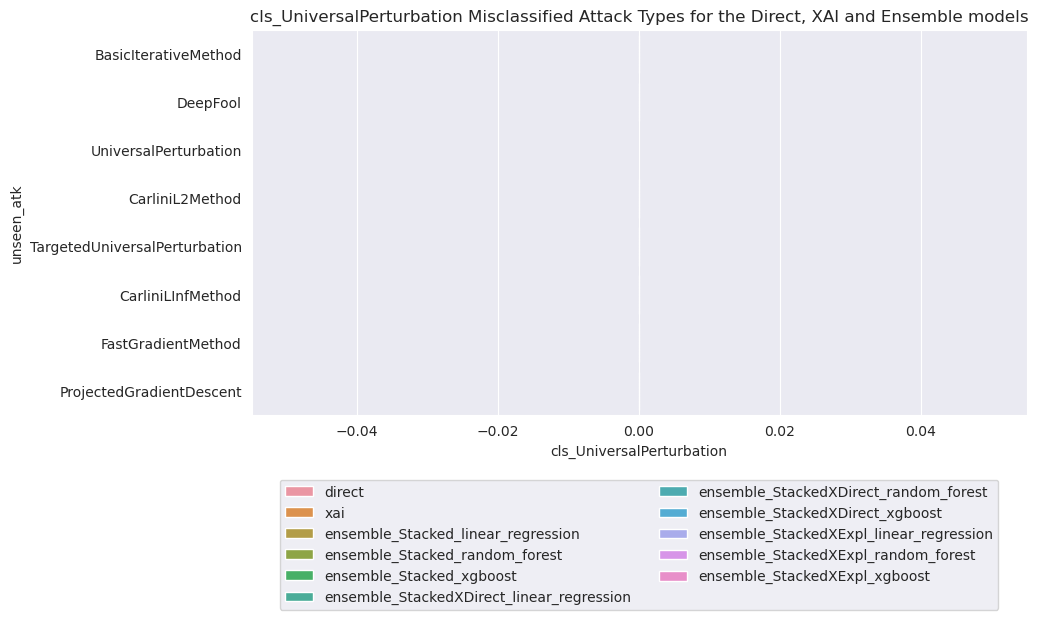

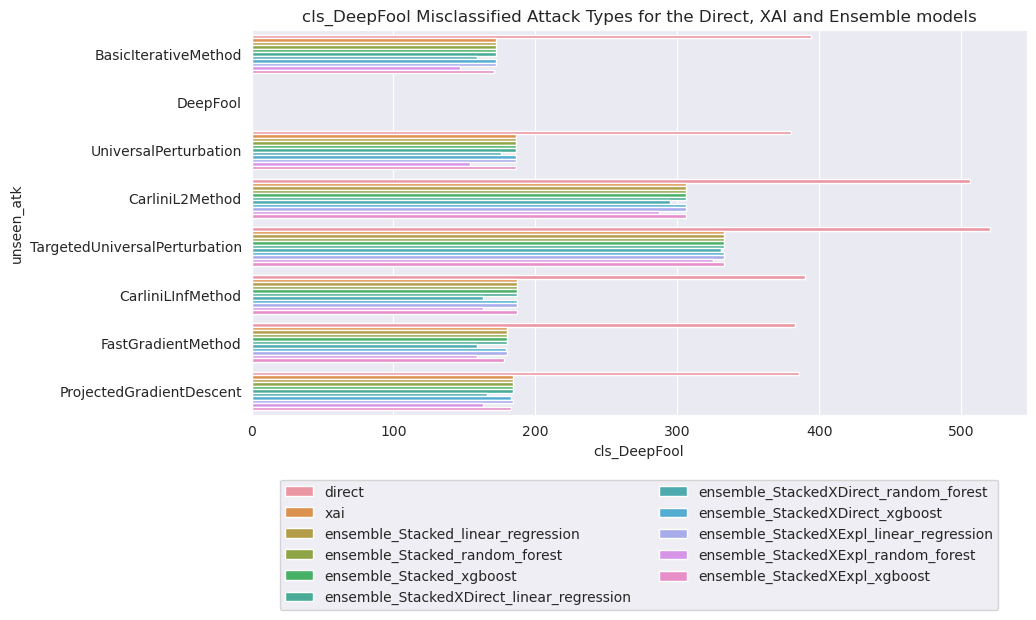

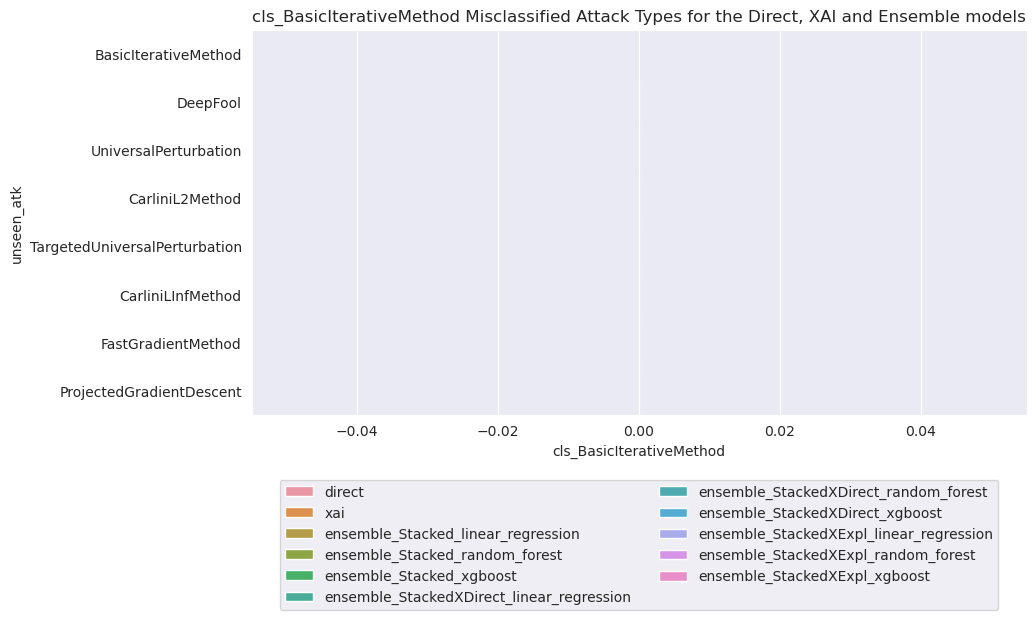

In [177]:
# get all the columns starting with 'cls' as a list
cls_cols = [col for col in results_df.columns if 'cls' in col]
# Plot the misclassified attack types
# plt.figure(figsize=(10, 5))
# sns.barplot(x='cls_CarliniL2Method', y='unseen_atk', data=results_df)

# plot a matrix of the above barplots in a loop for all cls_cols
for cls_col in cls_cols:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=cls_col, y='unseen_atk', hue='experiment_type', data=results_df)
    plt.title(f"{cls_col} Misclassified Attack Types for the Direct, XAI and Ensemble models")
    plt.legend(bbox_to_anchor=(0.5, -0.15),ncol=2, loc='upper center')
    plt.savefig(os.path.join(results_figs_dir, f"{cls_col}_misclassified_attack_wise_xai_direct_{dt.datetime.now().strftime('%H-%M-%S')}.png"), bbox_inches='tight', dpi=300)

## Explanations

In [ ]:
# Generate a force plot from the explanations
# Load the explanations
shap_values = np.load("/home/spatial01/RND/adversarial-detector/adversarial-detector-xai/results/Novel_DMIMO_29-07-24/Explanations/xai_direct, shap_values_xgboost_direct_1ATK_22-29-42.npy", allow_pickle=True)